In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# set GPU number
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# UNet

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define the module of UNet
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [4]:
# define UNet

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        #x,pr = self.depth_layer(x)
        #return x,pr
        return x

## Train dataset

In [5]:
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageOps
#from skimage import filters
from PIL import ImageFilter
import glob


torch.manual_seed(3)

class AcousticDataset(Dataset):
    def __init__(self,root='./BlenderFiles/dataset_float/',transform=None, train=True): #trans_trim
        self.transform = transform
        self.train = train
        self.root = root
        
        
        self.length=self.generate_files()
    def generate_files(self,interv=3):
        self.path2acfiles = []
        self.path2elefiles = []
        self.path2fakefiles = []
        self.path2frontfiles = []
        self.motion = []
        for i in range(3): #it was 1
            i=i*80
            for j in range(17):  #change the scope of i and j to determine how many images are used for training. It was 5
                if (j==2 and i==0) or j==7:
                    continue
                j=j*10
                path2pose = self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/record.txt'
                path=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/real_*.png'
                path2ele=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/ele_*.png'
                path2fake=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/sim_*.png'
                path2front=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/front_*.npy'
                
                #print(path)
                #path2mask=self.root+str(i).rjust(2,'0')+'/mask*.jpg'
            
                with open(path2pose) as f:
                    poselist = f.readlines()
                pathlist = glob.glob(path)
                pathlistele = glob.glob(path2ele)
                pathlistfake = glob.glob(path2fake)
                pathlistfront = glob.glob(path2front)
                pathlist.sort()
                pathlistele.sort()
                pathlistfake.sort()
                pathlistfront.sort()
                for k in range(interv,len(pathlist)-interv):
                    sublist = []
                    sublist.append(pathlist[k-interv])
                    sublist.append(pathlist[k])
                    sublist.append(pathlist[k+interv])

                    self.path2acfiles.append(sublist)
                
                    sublistele = []
                    sublistele.append(pathlistele[k-interv])
                    sublistele.append(pathlistele[k])
                    sublistele.append(pathlistele[k+interv])
                    self.path2elefiles.append(sublistele)
                    
                    sublistfake = []
                    sublistfake.append(pathlistfake[k-interv])
                    sublistfake.append(pathlistfake[k])
                    sublistfake.append(pathlistfake[k+interv])

                    self.path2fakefiles.append(sublistfake)
                    
                    self.path2frontfiles.append(pathlistfront[k])
                    
                    #idx_pre, p_previous = poselist[k-interv].split(' ')
                    #idx_cr, p_cr = poselist[k].split(' ')
                    #idx_next, p_next = poselist[k+interv].split(' ')
                    
                    p_previous = poselist[k-interv]
                    p_cr = poselist[k]
                    p_next = poselist[k+interv]
                
                    pose_previous = float(p_previous)
                    pose = float(p_cr)
                    pose_next = float(p_next)
                
                    motion1 = pose_previous-pose
                    motion2 = pose_next-pose
                
                    submotion=[]
                    submotion.append(motion1)
                    submotion.append(motion2)
                
                    self.motion.append(submotion)
                
                
                
        self.length=len(self.path2acfiles)
        return (self.length)

              

    
    def get_index(self):
        #idx = np.random.randint(self.length)
        idx = np.random.randint(1,22)
        return idx
    def __getitem__(self,idx):
        
        #idx = self.get_index()
        #print(idx)
        #path2image, path2label = self.lines[idx].split(' ')
        
        aclist=[]
        elelist=[]
        sublist = self.path2acfiles[idx]
        sublistele = self.path2elefiles[idx]
        sublistfake = self.path2fakefiles[idx]
        #sublistmask = self.path2maskfiles[idx]
        submotion = self.motion[idx]
        
        ac_previous=Image.open(sublist[0]).convert('L')
        ac=Image.open(sublist[1]).convert('L')
        ac_next=Image.open(sublist[2]).convert('L')
        
        ele_previous=Image.open(sublistele[0]).convert('L')
        ele=Image.open(sublistele[1]).convert('L')
        ele_next=Image.open(sublistele[2]).convert('L')
        
        fake_previous=Image.open(sublistfake[0]).convert('L')
        fake=Image.open(sublistfake[1]).convert('L')
        fake_next=Image.open(sublistfake[2]).convert('L')
        #mask_previous=Image.open(sublistmask[0]).convert('1')
        #mask=Image.open(sublistmask[1]).convert('1')
        #mask_next=Image.open(sublistmask[2]).convert('1')
        front_path = self.path2frontfiles[idx]
        front = np.load(front_path)
        
        front_resize = torch.tensor(front,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        #resize
        
      
        front_resize = F.interpolate(front_resize,(64,128), mode='bicubic')
        
        #front_resize = front_resize*6-1.5
        front_resize = 1/front_resize
        
        
        minimum_depth = 0.971+0.00299*400
        maximum_depth = 0.971+0.00299*1100
        front_resize[front_resize>maximum_depth] =maximum_depth
        front_resize[front_resize<minimum_depth] = minimum_depth
        
        front_resize = front_resize.squeeze()
        
        motion1 = submotion[0]/180.0*3.1415926
        motion2 = submotion[1]/180.0*3.1415926
        
        #ac = ac.resize((128,256))
        #ac_next = ac_next.resize((128,256))
        #ac_previous = ac_previous.resize((128,256))
        ac = ac.crop((0,400,128,1100))
        ele = ele.crop((0,400,128,1100))
        ac_next = ac_next.crop((0,400,128,1100))
        ac_previous = ac_previous.crop((0,400,128,1100))
        ele_next = ele_next.crop((0,400,128,1100))
        ele_previous = ele_previous.crop((0,400,128,1100))
        fake = fake.crop((0,400,128,1100))
        fake_next = fake_next.crop((0,400,128,1100))
        fake_previous = fake_previous.crop((0,400,128,1100))
        
        ac = ac.resize((128,512))
        ac_next = ac_next.resize((128,512))
        ac_previous = ac_previous.resize((128,512))
        
        ele = ele.resize((128,512))
        ele_next = ele_next.resize((128,512))
        ele_previous = ele_previous.resize((128,512))
        
        fake = fake.resize((128,512))
        fake_next = fake_next.resize((128,512))
        fake_previous = fake_previous.resize((128,512))
        
        ac_blur=ac.filter(ImageFilter.MedianFilter(7))
        ac_next_blur=ac_next.filter(ImageFilter.MedianFilter(7))
        ac_previous_blur=ac_previous.filter(ImageFilter.MedianFilter(7))
        
        ac=ac.filter(ImageFilter.MedianFilter(3))
        ac_next=ac_next.filter(ImageFilter.MedianFilter(3))
        ac_previous=ac_previous.filter(ImageFilter.MedianFilter(3))  
        
        #mask = ac_blur.point(lambda p: p > 30 and 255)
        #mask_previous = ac_previous_blur.point(lambda p: p > 30 and 255)  #27
        #mask_next = ac_next_blur.point(lambda p: p > 30 and 255)
        
        mask = ele.point(lambda p: p > 3 and 255)
        mask_previous = ele_previous.point(lambda p: p > 3 and 255)  #27
        mask_next = ele_next.point(lambda p: p > 3 and 255)

        #hflip = np.random.random() < 0.5
        hflip=False
        if hflip and self.train:
            ac=ImageOps.mirror(ac)
        
            ac_previous=ImageOps.mirror(ac_previous)
            
            ac_next=ImageOps.mirror(ac_next)
            
            fake=ImageOps.mirror(fake)
        
            fake_previous=ImageOps.mirror(fake_previous)
            
            fake_next=ImageOps.mirror(fake_next)
            
            
            
            ele=ImageOps.mirror(ele)
        
            ele_previous=ImageOps.mirror(ele_previous)
            
            ele_next=ImageOps.mirror(ele_next)
            
            mask=ImageOps.mirror(mask)
        
            mask_previous=ImageOps.mirror(mask_previous)
            
            mask_next=ImageOps.mirror(mask_next)
        
      
        
        if self.transform is not None:
            
            ac = self.transform(ac)
            ac_previous = self.transform(ac_previous)
            ac_next = self.transform(ac_next)
            
            fake = self.transform(fake)
            fake_previous = self.transform(fake_previous)
            fake_next = self.transform(fake_next)
            
            ele = self.transform(ele)
            ele_previous = self.transform(ele_previous)
            ele_next = self.transform(ele_next)
          
            mask = self.transform(mask)
            mask_previous = self.transform(mask_previous)
            mask_next = self.transform(mask_next)
            
            #masker = self.transform(masker)
            motiona = torch.zeros(6)
            motionb = torch.zeros(6)
            
            motion1 = torch.tensor(motion1)
            motion2 = torch.tensor(motion2)
            
            motiona[3] = -motion1
            motionb[3] = -motion2
            
           
            #ac = fake
            #ac_next = fake_next
            #ac_previous = fake_previous
            
        return ac, ele, mask, ac_previous, ele_previous, mask_previous, ac_next, ele_next, mask_next, motiona, motionb, front_resize
    def __len__(self):
        return self.length

## Train dataset trial

1234
tensor([0.0000, 0.0000, 0.0000, 0.1099, 0.0000, 0.0000])
tensor([ 0.0000,  0.0000,  0.0000, -0.1099,  0.0000,  0.0000])
torch.Size([1, 512, 128])


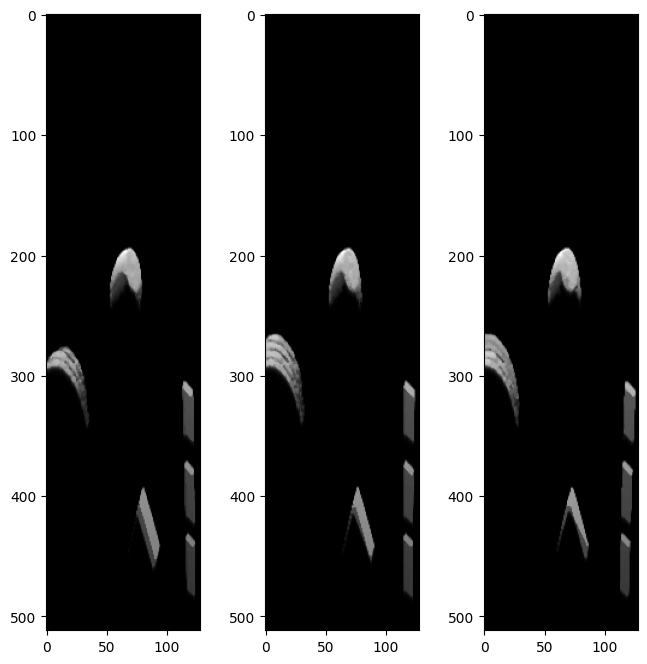

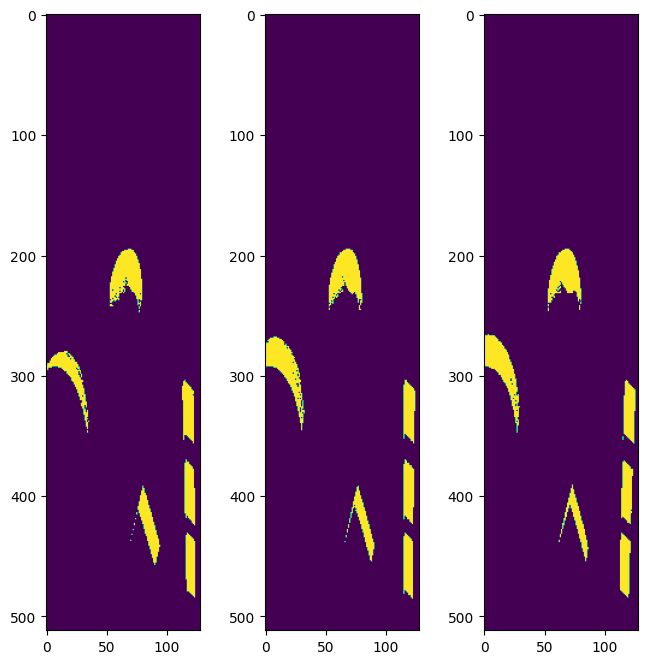

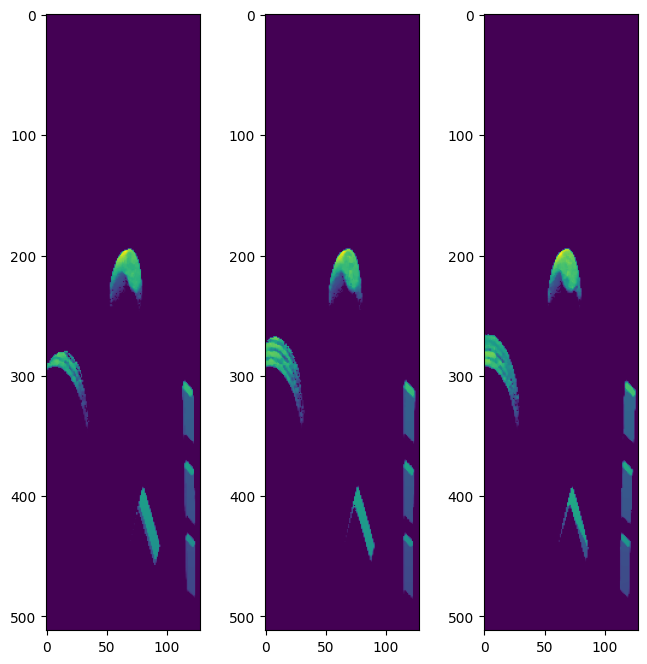

In [6]:
transformations = transforms.Compose([transforms.ToTensor()])
acoustic_dataset = AcousticDataset(transform=transformations,train=True)
print(len(acoustic_dataset))
ac, ele, mask, ac_previous, ele_previous, mask_previous, ac_next, ele_next, mask_next, motion1, motion2, front_resize= acoustic_dataset[15]

print(motion1)
print(motion2)

print(ac.shape)
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(ac_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(ac.squeeze())
plt.subplot(1,3,3)
plt.imshow(ac_next.squeeze())
plt.rcParams['image.cmap'] = 'viridis'
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(mask_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(mask.squeeze())
plt.subplot(1,3,3)
plt.imshow(mask_next.squeeze())
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(mask_previous.squeeze()*ac_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(mask.squeeze()*ac.squeeze())
plt.subplot(1,3,3)
plt.imshow(mask_next.squeeze()*ac_next.squeeze())

In [7]:
from torch.utils.data import DataLoader
train_dl = DataLoader(acoustic_dataset,batch_size=4,shuffle=True)

# Test

In [8]:
class TestDataset(Dataset):
    def __init__(self,root='./BlenderFiles/dataset_float/',transform=None, train=False): #trans_trim
        self.transform = transform
        self.train = train
        self.root = root
        
        
        self.length=self.generate_files()
    def generate_files(self,interv=0):
        self.path2acfiles = []
        self.path2elefiles = []
        self.path2fakefiles = []
        self.path2frontfiles = []
        self.motion = []
        for i in range(3):
            i=i*80
            for j in range(17): # change here to determine test set
                if j==2 and i==0: # change here to determine test set
                    continue
                #if  j==7:
                #if j>-1:
                
                if  j==7:
                    j=j*10
                    path2pose = self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/record.txt'
                    path=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/real_*.png'
                    path2ele=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/ele_*.png'
                    path2fake=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/sim_*.png'
                    path2front=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/front_*.npy'
                
                
            
                    with open(path2pose) as f:
                        poselist = f.readlines()
                    pathlist = glob.glob(path)
                    pathlistele = glob.glob(path2ele)
                    pathlistfake = glob.glob(path2fake)
                    pathlistfront = glob.glob(path2front)
                    pathlist.sort()
                    pathlistele.sort()
                    pathlistfake.sort()
                    pathlistfront.sort()
                    for k in range(interv,len(pathlist)-interv):
                        sublist = []
                        sublist.append(pathlist[k-interv])
                        sublist.append(pathlist[k])
                        sublist.append(pathlist[k+interv])

                        self.path2acfiles.append(sublist)
                
                        sublistele = []
                        sublistele.append(pathlistele[k-interv])
                        sublistele.append(pathlistele[k])
                        sublistele.append(pathlistele[k+interv])
                        self.path2elefiles.append(sublistele)
                    
                        sublistfake = []
                        sublistfake.append(pathlistfake[k-interv])
                        sublistfake.append(pathlistfake[k])
                        sublistfake.append(pathlistfake[k+interv])

                        self.path2fakefiles.append(sublistfake)
                    
                        self.path2frontfiles.append(pathlistfront[k])
                    
                        #idx_pre, p_previous = poselist[k-interv].split(' ')
                        #idx_cr, p_cr = poselist[k].split(' ')
                        #idx_next, p_next = poselist[k+interv].split(' ')
                    
                        p_previous = poselist[k-interv]
                        p_cr = poselist[k]
                        p_next = poselist[k+interv]
                
                        pose_previous = float(p_previous)
                        pose = float(p_cr)
                        pose_next = float(p_next)
                
                        motion1 = pose_previous-pose
                        motion2 = pose_next-pose
                
                        submotion=[]
                        submotion.append(motion1)
                        submotion.append(motion2)
                
                        self.motion.append(submotion)
                
                
                
        self.length=len(self.path2acfiles)
        return (self.length)

              

    
    def get_index(self):
        #idx = np.random.randint(self.length)
        idx = np.random.randint(1,22)
        return idx
    def __getitem__(self,idx):
        
        #idx = self.get_index()
        #print(idx)
        #path2image, path2label = self.lines[idx].split(' ')
        
        aclist=[]
        elelist=[]
        sublist = self.path2acfiles[idx]
        sublistele = self.path2elefiles[idx]
        sublistfake = self.path2fakefiles[idx]
        #sublistmask = self.path2maskfiles[idx]
        submotion = self.motion[idx]
        
        ac_previous=Image.open(sublist[0]).convert('L')
        ac=Image.open(sublist[1]).convert('L')
        ac_next=Image.open(sublist[2]).convert('L')
        
        ele_previous=Image.open(sublistele[0]).convert('L')
        ele=Image.open(sublistele[1]).convert('L')
        ele_next=Image.open(sublistele[2]).convert('L')
        
        fake_previous=Image.open(sublistfake[0]).convert('L')
        fake=Image.open(sublistfake[1]).convert('L')
        fake_next=Image.open(sublistfake[2]).convert('L')
        #mask_previous=Image.open(sublistmask[0]).convert('1')
        #mask=Image.open(sublistmask[1]).convert('1')
        #mask_next=Image.open(sublistmask[2]).convert('1')
        
        front_path = self.path2frontfiles[idx]
        front = np.load(front_path)
        
        front_resize = torch.tensor(front,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        #resize
        
      
        front_resize = F.interpolate(front_resize,(64,128), mode='bicubic')
        
        #front_resize = front_resize*6-1.5
        front_resize = 1/front_resize
        
        
        minimum_depth = 0.971+0.00299*400
        maximum_depth = 0.971+0.00299*1100
        front_resize[front_resize>maximum_depth] =maximum_depth
        front_resize[front_resize<minimum_depth] = minimum_depth
        
        front_resize = front_resize.squeeze()
        
        
        motion1 = submotion[0]/180.0*3.1415926
        motion2 = submotion[1]/180.0*3.1415926
        
        #ac = ac.resize((128,256))
        #ac_next = ac_next.resize((128,256))
        #ac_previous = ac_previous.resize((128,256))
        ac = ac.crop((0,400,128,1100))
        ele = ele.crop((0,400,128,1100))
        ac_next = ac_next.crop((0,400,128,1100))
        ac_previous = ac_previous.crop((0,400,128,1100))
        ele_next = ele_next.crop((0,400,128,1100))
        ele_previous = ele_previous.crop((0,400,128,1100))
        fake = fake.crop((0,400,128,1100))
        fake_next = fake_next.crop((0,400,128,1100))
        fake_previous = fake_previous.crop((0,400,128,1100))
        
        ac = ac.resize((128,512))
        ac_next = ac_next.resize((128,512))
        ac_previous = ac_previous.resize((128,512))
        
        ele = ele.resize((128,512))
        ele_next = ele_next.resize((128,512))
        ele_previous = ele_previous.resize((128,512))
        
        fake = fake.resize((128,512))
        fake_next = fake_next.resize((128,512))
        fake_previous = fake_previous.resize((128,512))
        
        ac_blur=ac.filter(ImageFilter.MedianFilter(7))
        ac_next_blur=ac_next.filter(ImageFilter.MedianFilter(7))
        ac_previous_blur=ac_previous.filter(ImageFilter.MedianFilter(7))
        
        ac=ac.filter(ImageFilter.MedianFilter(3))
        ac_next=ac_next.filter(ImageFilter.MedianFilter(3))
        ac_previous=ac_previous.filter(ImageFilter.MedianFilter(3))  
        
        #mask = ac_blur.point(lambda p: p > 30 and 255)
        #mask_previous = ac_previous_blur.point(lambda p: p > 30 and 255)  #27
        #mask_next = ac_next_blur.point(lambda p: p > 30 and 255)
        
        mask = ele.point(lambda p: p > 3 and 255) #22
        mask_previous = ele_previous.point(lambda p: p > 3 and 255)  #27
        mask_next = ele_next.point(lambda p: p > 3 and 255)

        #hflip = np.random.random() < 0.5
        hflip=False
        if hflip:
            ac=ImageOps.mirror(ac)
        
            ac_previous=ImageOps.mirror(ac_previous)
            
            ac_next=ImageOps.mirror(ac_next)
            
            fake=ImageOps.mirror(fake)
        
            fake_previous=ImageOps.mirror(fake_previous)
            
            fake_next=ImageOps.mirror(fake_next)
            
            
            
            ele=ImageOps.mirror(ele)
        
            ele_previous=ImageOps.mirror(ele_previous)
            
            ele_next=ImageOps.mirror(ele_next)
            
            mask=ImageOps.mirror(mask)
        
            mask_previous=ImageOps.mirror(mask_previous)
            
            mask_next=ImageOps.mirror(mask_next)
        
      
        
        if self.transform is not None:
            
            ac = self.transform(ac)
            ac_previous = self.transform(ac_previous)
            ac_next = self.transform(ac_next)
            
            fake = self.transform(fake)
            fake_previous = self.transform(fake_previous)
            fake_next = self.transform(fake_next)
            
            ele = self.transform(ele)
            ele_previous = self.transform(ele_previous)
            ele_next = self.transform(ele_next)
          
            mask = self.transform(mask)
            mask_previous = self.transform(mask_previous)
            mask_next = self.transform(mask_next)
            
            #masker = self.transform(masker)
            motiona = torch.zeros(6)
            motionb = torch.zeros(6)
            
            motion1 = torch.tensor(motion1)
            motion2 = torch.tensor(motion2)
            
            motiona[3] = motion1
            motionb[3] = motion2
            
           
            #ac = fake
            #ac_next = fake_next
            #ac_previous = fake_previous
            
        return ac, ele, mask, ac_previous, ele_previous, mask_previous, ac_next, ele_next, mask_next, motiona, motionb, front_resize
    def __len__(self):
        return self.length

100
tensor([0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0.])
torch.Size([1, 512, 128])


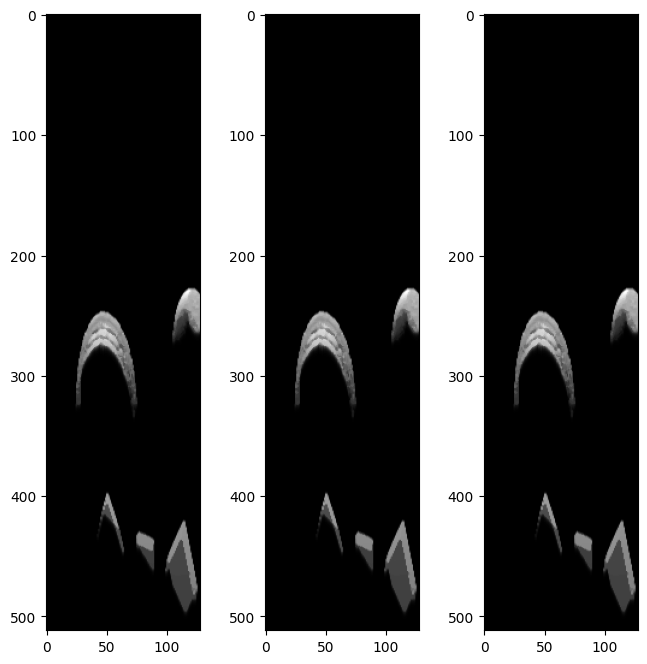

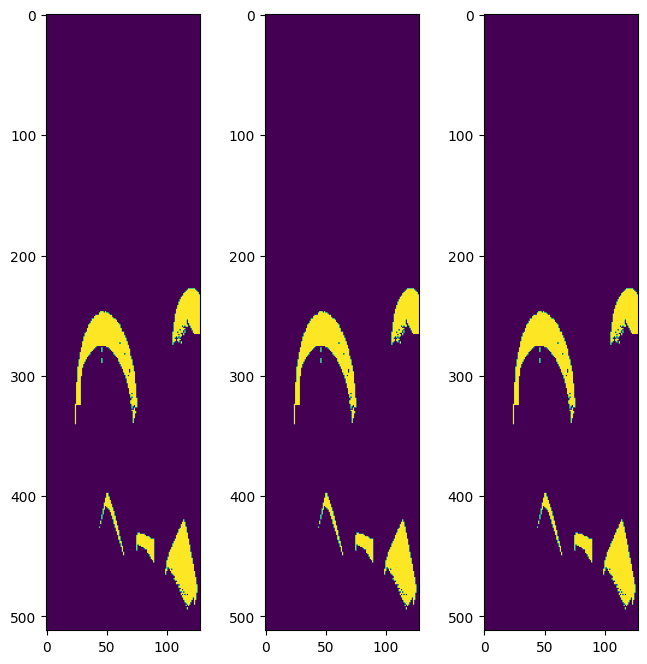

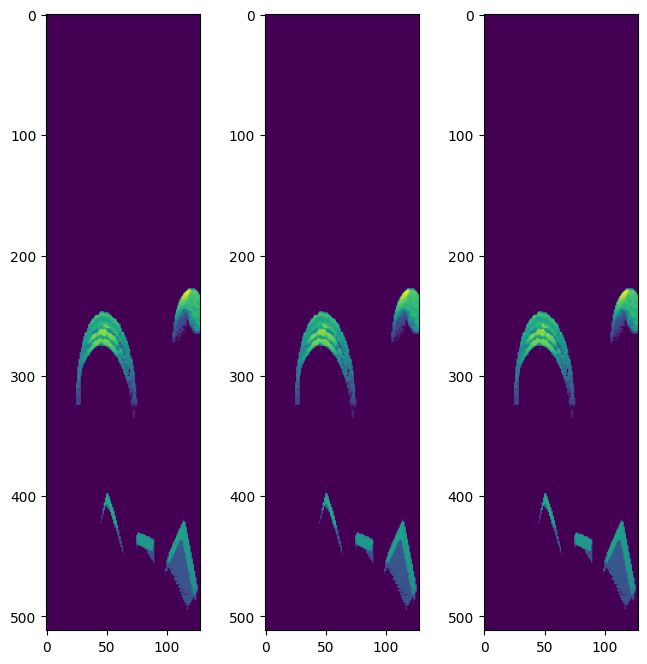

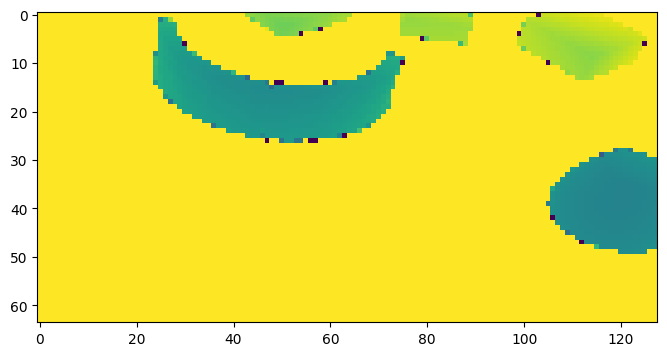

In [9]:
transformations = transforms.Compose([transforms.ToTensor()])
test_dataset = TestDataset(transform=transformations,train=False)
print(len(test_dataset))
ac, ele, mask, ac_previous, ele_previous, mask_previous, ac_next, ele_next, mask_next, motion1, motion2, front_resize= test_dataset[15]

print(motion1)
print(motion2)

print(ac.shape)
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(ac_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(ac.squeeze())
plt.subplot(1,3,3)
plt.imshow(ac_next.squeeze())
plt.rcParams['image.cmap'] = 'viridis'
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(mask_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(mask.squeeze())
plt.subplot(1,3,3)
plt.imshow(mask_next.squeeze())
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(mask_previous.squeeze()*ac_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(mask.squeeze()*ac.squeeze())
plt.subplot(1,3,3)
plt.imshow(mask_next.squeeze()*ac_next.squeeze())

plt.figure(figsize=(8,8))
plt.imshow(front_resize.squeeze())

In [10]:
from torch.utils.data import DataLoader
test_dl = DataLoader(test_dataset,batch_size=1,shuffle=False)

### AllData

In [11]:
class AllDataDataset(Dataset):
    def __init__(self,root='./BlenderFiles/dataset_float/',transform=None, train=False):
        self.transform = transform
        self.train = train
        self.root = root
        
        
        self.length=self.generate_files()
    def generate_files(self,interv=0):
        self.path2acfiles = []
        self.path2elefiles = []
        self.path2fakefiles = []
        self.path2frontfiles = []
        self.motion = []
        for i in range(3):
            i=i*80
            for j in range(17): # change here to determine test set
                if j==2 and i==0: # change here to determine test set
                    continue
                #if  j==7:
                if j>-1:
                    j=j*10
                    path2pose = self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/record.txt'
                    path=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/real_*.png'
                    path2ele=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/ele_*.png'
                    path2fake=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/sim_*.png'
                    path2front=self.root+str(i).rjust(3,'0')+'_'+str(j).rjust(3,'0')+'/front_*.npy'
                
                
            
                    with open(path2pose) as f:
                        poselist = f.readlines()
                    pathlist = glob.glob(path)
                    pathlistele = glob.glob(path2ele)
                    pathlistfake = glob.glob(path2fake)
                    pathlistfront = glob.glob(path2front)
                    pathlist.sort()
                    pathlistele.sort()
                    pathlistfake.sort()
                    pathlistfront.sort()
                    for k in range(interv,len(pathlist)-interv):
                        sublist = []
                        sublist.append(pathlist[k-interv])
                        sublist.append(pathlist[k])
                        sublist.append(pathlist[k+interv])

                        self.path2acfiles.append(sublist)
                
                        sublistele = []
                        sublistele.append(pathlistele[k-interv])
                        sublistele.append(pathlistele[k])
                        sublistele.append(pathlistele[k+interv])
                        self.path2elefiles.append(sublistele)
                    
                        sublistfake = []
                        sublistfake.append(pathlistfake[k-interv])
                        sublistfake.append(pathlistfake[k])
                        sublistfake.append(pathlistfake[k+interv])

                        self.path2fakefiles.append(sublistfake)
                    
                        self.path2frontfiles.append(pathlistfront[k])
                    
                        #idx_pre, p_previous = poselist[k-interv].split(' ')
                        #idx_cr, p_cr = poselist[k].split(' ')
                        #idx_next, p_next = poselist[k+interv].split(' ')
                    
                        p_previous = poselist[k-interv]
                        p_cr = poselist[k]
                        p_next = poselist[k+interv]
                
                        pose_previous = float(p_previous)
                        pose = float(p_cr)
                        pose_next = float(p_next)
                
                        motion1 = pose_previous-pose
                        motion2 = pose_next-pose
                
                        submotion=[]
                        submotion.append(motion1)
                        submotion.append(motion2)
                
                        self.motion.append(submotion)
                
                
                
        self.length=len(self.path2acfiles)
        return (self.length)

              

    
    def get_index(self):
        #idx = np.random.randint(self.length)
        idx = np.random.randint(1,22)
        return idx
    def __getitem__(self,idx):
        
        #idx = self.get_index()
        #print(idx)
        #path2image, path2label = self.lines[idx].split(' ')
        
        aclist=[]
        elelist=[]
        sublist = self.path2acfiles[idx]
        sublistele = self.path2elefiles[idx]
        sublistfake = self.path2fakefiles[idx]
        #sublistmask = self.path2maskfiles[idx]
        submotion = self.motion[idx]
        
        ac_previous=Image.open(sublist[0]).convert('L')
        ac=Image.open(sublist[1]).convert('L')
        ac_next=Image.open(sublist[2]).convert('L')
        
        ele_previous=Image.open(sublistele[0]).convert('L')
        ele=Image.open(sublistele[1]).convert('L')
        ele_next=Image.open(sublistele[2]).convert('L')
        
        fake_previous=Image.open(sublistfake[0]).convert('L')
        fake=Image.open(sublistfake[1]).convert('L')
        fake_next=Image.open(sublistfake[2]).convert('L')
        #mask_previous=Image.open(sublistmask[0]).convert('1')
        #mask=Image.open(sublistmask[1]).convert('1')
        #mask_next=Image.open(sublistmask[2]).convert('1')
        
        front_path = self.path2frontfiles[idx]
        front = np.load(front_path)
        
        front_resize = torch.tensor(front,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        #resize
        
      
        front_resize = F.interpolate(front_resize,(64,128), mode='bicubic')
        
        #front_resize = front_resize*6-1.5
        front_resize = 1/front_resize
        
        
        minimum_depth = 0.971+0.00299*400
        maximum_depth = 0.971+0.00299*1100
        front_resize[front_resize>maximum_depth] =maximum_depth
        front_resize[front_resize<minimum_depth] = minimum_depth
        
        front_resize = front_resize.squeeze()
        
        
        motion1 = submotion[0]/180.0*3.1415926
        motion2 = submotion[1]/180.0*3.1415926
        
        #ac = ac.resize((128,256))
        #ac_next = ac_next.resize((128,256))
        #ac_previous = ac_previous.resize((128,256))
        ac = ac.crop((0,400,128,1100))
        ele = ele.crop((0,400,128,1100))
        ac_next = ac_next.crop((0,400,128,1100))
        ac_previous = ac_previous.crop((0,400,128,1100))
        ele_next = ele_next.crop((0,400,128,1100))
        ele_previous = ele_previous.crop((0,400,128,1100))
        fake = fake.crop((0,400,128,1100))
        fake_next = fake_next.crop((0,400,128,1100))
        fake_previous = fake_previous.crop((0,400,128,1100))
        
        ac = ac.resize((128,512))
        ac_next = ac_next.resize((128,512))
        ac_previous = ac_previous.resize((128,512))
        
        ele = ele.resize((128,512))
        ele_next = ele_next.resize((128,512))
        ele_previous = ele_previous.resize((128,512))
        
        fake = fake.resize((128,512))
        fake_next = fake_next.resize((128,512))
        fake_previous = fake_previous.resize((128,512))
        
        ac_blur=ac.filter(ImageFilter.MedianFilter(7))
        ac_next_blur=ac_next.filter(ImageFilter.MedianFilter(7))
        ac_previous_blur=ac_previous.filter(ImageFilter.MedianFilter(7))
        
        ac=ac.filter(ImageFilter.MedianFilter(3))
        ac_next=ac_next.filter(ImageFilter.MedianFilter(3))
        ac_previous=ac_previous.filter(ImageFilter.MedianFilter(3))  
        
        #mask = ac_blur.point(lambda p: p > 30 and 255)
        #mask_previous = ac_previous_blur.point(lambda p: p > 30 and 255)  #27
        #mask_next = ac_next_blur.point(lambda p: p > 30 and 255)
        
        mask = ele.point(lambda p: p > 3 and 255) #22
        mask_previous = ele_previous.point(lambda p: p > 3 and 255)  #27
        mask_next = ele_next.point(lambda p: p > 3 and 255)

        #hflip = np.random.random() < 0.5
        hflip=False
        if hflip:
            ac=ImageOps.mirror(ac)
        
            ac_previous=ImageOps.mirror(ac_previous)
            
            ac_next=ImageOps.mirror(ac_next)
            
            fake=ImageOps.mirror(fake)
        
            fake_previous=ImageOps.mirror(fake_previous)
            
            fake_next=ImageOps.mirror(fake_next)
            
            
            
            ele=ImageOps.mirror(ele)
        
            ele_previous=ImageOps.mirror(ele_previous)
            
            ele_next=ImageOps.mirror(ele_next)
            
            mask=ImageOps.mirror(mask)
        
            mask_previous=ImageOps.mirror(mask_previous)
            
            mask_next=ImageOps.mirror(mask_next)
        
      
        
        if self.transform is not None:
            
            ac = self.transform(ac)
            ac_previous = self.transform(ac_previous)
            ac_next = self.transform(ac_next)
            
            fake = self.transform(fake)
            fake_previous = self.transform(fake_previous)
            fake_next = self.transform(fake_next)
            
            ele = self.transform(ele)
            ele_previous = self.transform(ele_previous)
            ele_next = self.transform(ele_next)
          
            mask = self.transform(mask)
            mask_previous = self.transform(mask_previous)
            mask_next = self.transform(mask_next)
            
            #masker = self.transform(masker)
            motiona = torch.zeros(6)
            motionb = torch.zeros(6)
            
            motion1 = torch.tensor(motion1)
            motion2 = torch.tensor(motion2)
            
            motiona[3] = motion1
            motionb[3] = motion2
            
           
            #ac = fake
            #ac_next = fake_next
            #ac_previous = fake_previous
            
        return ac, ele, mask, ac_previous, ele_previous, mask_previous, ac_next, ele_next, mask_next, motiona, motionb, front_resize
    def __len__(self):
        return self.length

1616
tensor([0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0.])
torch.Size([1, 512, 128])


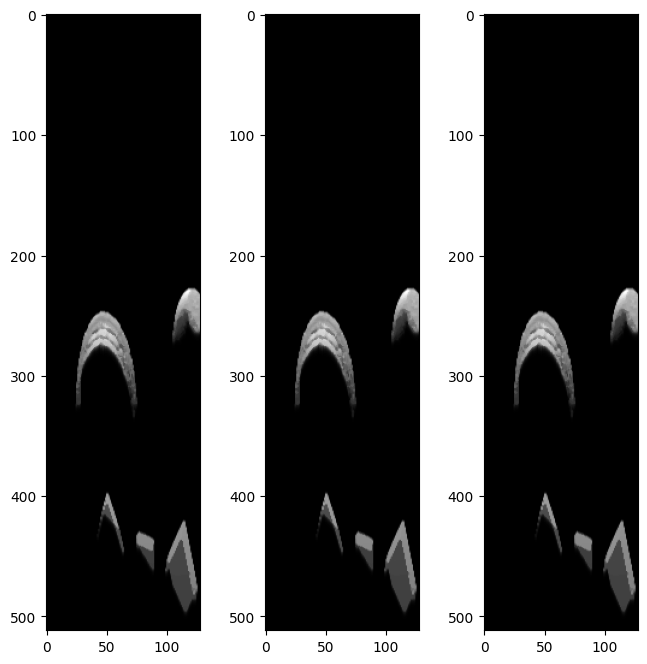

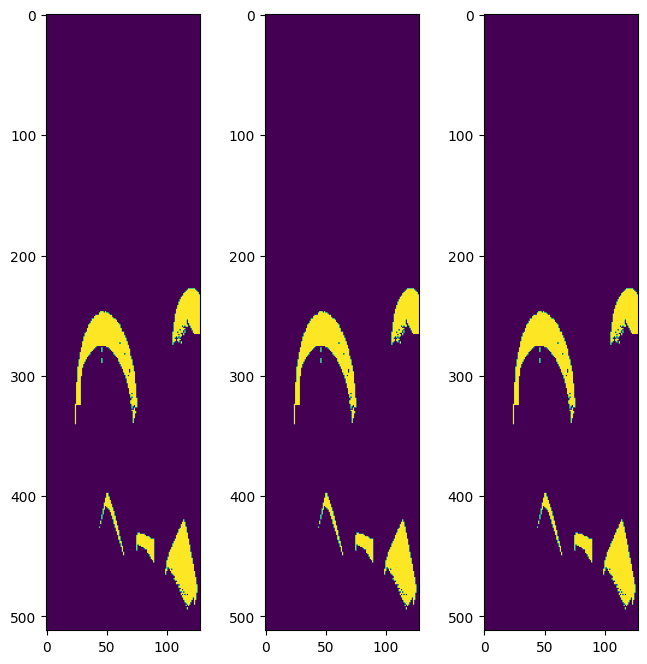

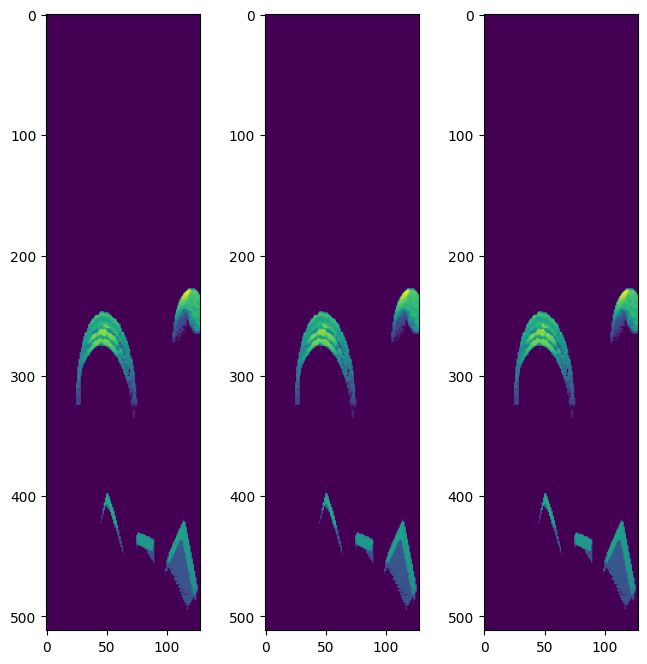

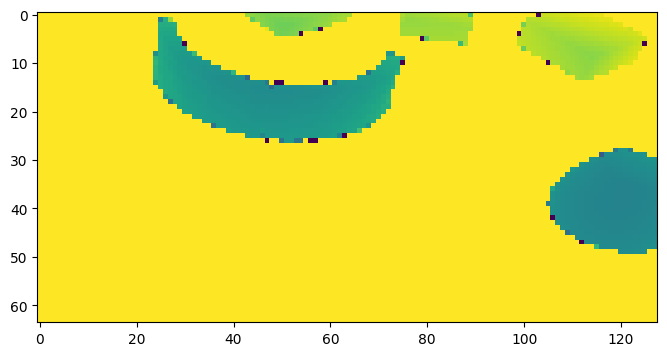

In [12]:
transformations = transforms.Compose([transforms.ToTensor()])
alldata_dataset = AllDataDataset(transform=transformations,train=False)
print(len(alldata_dataset))
ac, ele, mask, ac_previous, ele_previous, mask_previous, ac_next, ele_next, mask_next, motion1, motion2, front_resize= test_dataset[15]

print(motion1)
print(motion2)

print(ac.shape)
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(ac_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(ac.squeeze())
plt.subplot(1,3,3)
plt.imshow(ac_next.squeeze())
plt.rcParams['image.cmap'] = 'viridis'
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(mask_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(mask.squeeze())
plt.subplot(1,3,3)
plt.imshow(mask_next.squeeze())
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(mask_previous.squeeze()*ac_previous.squeeze())
plt.subplot(1,3,2)
plt.imshow(mask.squeeze()*ac.squeeze())
plt.subplot(1,3,3)
plt.imshow(mask_next.squeeze()*ac_next.squeeze())

plt.figure(figsize=(8,8))
plt.imshow(front_resize.squeeze())

In [13]:
from torch.utils.data import DataLoader
all_dl = DataLoader(alldata_dataset,batch_size=1,shuffle=True)

## warp

In [14]:
PI = torch.acos(torch.zeros(1)).item() * 2

def ele2pc(ele,mask): #depth: batch, channel, elevation, azimuth [b,c,e,a]  [1,1,32,128]
    
    scale=700/512
    angle=18.0
    
    ele = ele*mask
    ele = ele*angle-angle/2
        
    
    #print(ele.shape)
    aa = (ele<9)
    bb = (ele>-9)
    valid = (aa&bb)
  
    
    ele=ele/180.0*PI
    #global pixel_coords
    b,c,e,a = ele.size()
    valid = valid.reshape(b,-1)
    
    
    i_range = torch.arange(0, e).view(1, e, 1).expand(1,e,a).type_as(ele)*(scale*0.00299)+0.971+400*(0.00299)  # 48.55 optical camera aperture
    i_range = i_range
    j_range = torch.arange(0, a).view(1, 1, a).expand(1,e,a).type_as(ele)/128*(30.0)-(30.0/2)  #-32
    j_range = j_range/180.0*PI
    ones = torch.ones(1,e,a).type_as(ele)
    
    #print(i_range.shape)
    

    
    pixel_coords = torch.stack((j_range, i_range, ones), dim=1)
    
    
    current_pixel_coords = pixel_coords[:,:,:e,:a].expand(b,3,e,a)
    
    ones_exp = torch.ones(b,e,a).type_as(ele)

    ele_exp = torch.stack((ones_exp, ones_exp, ele.squeeze(1)), dim=1)
    
    current_pixel_coords= ele_exp*current_pixel_coords
    
    #print(current_pixel_coords.shape)
   
    #print(current_pixel_coords[:,2,:,:]/PI*180)
    
    x = current_pixel_coords[:,1,:,:]*torch.cos(current_pixel_coords[:,0,:,:])*torch.cos(current_pixel_coords[:,2,:,:])
    y = current_pixel_coords[:,1,:,:]*torch.sin(current_pixel_coords[:,0,:,:])*torch.cos(current_pixel_coords[:,2,:,:])
    z = current_pixel_coords[:,1,:,:]*torch.sin(current_pixel_coords[:,2,:,:])
    
   
    pc = torch.stack((x, y, z), dim=1)
    #pc = pc*mask
    #print(pc.shape)
    
    pc = pc.view(b,3,-1)
    #pc = pc.transpose(1,2)
    
    #valid =valid.unsqueeze(2)
    
    #print(pc.shape)
    
    return pc,valid

In [15]:
def pc2pixel(pc, proj_c2p_rot, proj_c2p_tr,valid=None):
    """Transform coordinates in the camera frame to the pixel frame.
    Args:
        pc: point cloud in the first camera coordinates system -- [B, 3, N]
        proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
        proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
    Returns:
        array of [-1,1] coordinates -- [B, 2, H, W]
    """
    scale=700/512
    
    
    w = 128
    h = 512
    b, n, _ = pc.size()
   
    if proj_c2p_rot is not None:
        pcoords = proj_c2p_rot @ pc
    else:
        pcoords = pc

    if proj_c2p_tr is not None:
        pcoords = pcoords + proj_c2p_tr  # [B, 3, H*W]
    X = pcoords[:, 0]
    Y = pcoords[:, 1]
    Z = pcoords[:, 2] #.clamp(min=1e-3)
    
    
    r = torch.sign(X)*torch.sqrt(X**2+Y**2+Z**2)
    theta = torch.atan(Y/X)
    phi = torch.atan(Z/torch.sqrt(X**2+Y**2))

    
    x_norm = (theta/3.1415926*180.0+15.0)/(30.0/128.0)
    y_norm = (r-0.971-400*0.00299)/(scale*0.00299)
   
    
    

    x_norm = 2*x_norm/(w-1) - 1  # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
    y_norm = 2*y_norm/(h-1) - 1  # Idem [B, H*W]

    pixel_coords = torch.stack([x_norm, y_norm], dim=2)  # [B, H*W, 2]
    return pixel_coords.reshape(b,h,w,2)


def euler2mat(angle):
    """Convert euler angles to rotation matrix.
     Reference: https://github.com/pulkitag/pycaffe-utils/blob/master/rot_utils.py#L174
    Args:
        angle: rotation angle along 3 axis (in radians) -- size = [B, 3]
    Returns:
        Rotation matrix corresponding to the euler angles -- size = [B, 3, 3]
    """
    B = angle.size(0)
    x, y, z = angle[:,0], angle[:,1], angle[:,2]

    cosz = torch.cos(z)
    sinz = torch.sin(z)

    zeros = z.detach()*0
    ones = zeros.detach()+1
    zmat = torch.stack([cosz, -sinz, zeros,
                        sinz,  cosz, zeros,
                        zeros, zeros,  ones], dim=1).reshape(B, 3, 3)

    cosy = torch.cos(y)
    siny = torch.sin(y)

    ymat = torch.stack([cosy, zeros,  siny,
                        zeros,  ones, zeros,
                        -siny, zeros,  cosy], dim=1).reshape(B, 3, 3)

    cosx = torch.cos(x)
    sinx = torch.sin(x)

    xmat = torch.stack([ones, zeros, zeros,
                        zeros,  cosx, -sinx,
                        zeros,  sinx,  cosx], dim=1).reshape(B, 3, 3)

    rotMat = xmat @ ymat @ zmat
    return rotMat


def quat2mat(quat):
    """Convert quaternion coefficients to rotation matrix.
    Args:
        quat: first three coeff of quaternion of rotation. fourht is then computed to have a norm of 1 -- size = [B, 3]
    Returns:
        Rotation matrix corresponding to the quaternion -- size = [B, 3, 3]
    """
    norm_quat = torch.cat([quat[:,:1].detach()*0 + 1, quat], dim=1)
    norm_quat = norm_quat/norm_quat.norm(p=2, dim=1, keepdim=True)
    w, x, y, z = norm_quat[:,0], norm_quat[:,1], norm_quat[:,2], norm_quat[:,3]

    B = quat.size(0)

    w2, x2, y2, z2 = w.pow(2), x.pow(2), y.pow(2), z.pow(2)
    wx, wy, wz = w*x, w*y, w*z
    xy, xz, yz = x*y, x*z, y*z

    rotMat = torch.stack([w2 + x2 - y2 - z2, 2*xy - 2*wz, 2*wy + 2*xz,
                          2*wz + 2*xy, w2 - x2 + y2 - z2, 2*yz - 2*wx,
                          2*xz - 2*wy, 2*wx + 2*yz, w2 - x2 - y2 + z2], dim=1).reshape(B, 3, 3)
    return rotMat


def pose_vec2mat(vec, rotation_mode='euler'):
    """
    Convert 6DoF parameters to transformation matrix.
    Args:s
        vec: 6DoF parameters in the order of tx, ty, tz, rx, ry, rz -- [B, 6]
    Returns:
        A transformation matrix -- [B, 3, 4]
    """
    translation = vec[:, :3].unsqueeze(-1)  # [B, 3, 1]


    B,_,_=translation.shape
    rot = vec[:,3:]
    if rotation_mode == 'euler':
        rot_mat = euler2mat(rot)  # [B, 3, 3]
    elif rotation_mode == 'quat':
        rot_mat = quat2mat(rot)  # [B, 3, 3]
    one_vector = torch.tensor([0.0,0.0,0.0,1.0]).repeat(B,1).unsqueeze(1).cuda()
    #print(one_vector.shape)
    transform_mat = torch.cat([rot_mat, translation], dim=2)  # [B, 3, 4]
    #print(transform_mat.shape)
    transform_mat = torch.cat([transform_mat, one_vector], dim=1)
    return transform_mat

def inverse_warp(ac_next, ele,mask, pose, rotation_mode='euler', padding_mode='zeros'):
    """
    Inverse warp a source image to the target image plane.
    Args:
        img: the source image (where to sample pixels) -- [B, 3, H, W]
        depth: depth map of the target image -- [B, H, W]
        pose: 6DoF pose parameters from target to source -- [B, 6]
        intrinsics: camera intrinsic matrix -- [B, 3, 3]
    Returns:
        projected_img: Source image warped to the target image plane
        valid_points: Boolean array indicating point validity
    """


    batch_size, _, img_height, img_width = ac_next.size()

    cam_coords,valid = ele2pc(ele,mask)  # [B,3,H,W]

    
    pose_mat = pose_vec2mat(pose, rotation_mode)  # [B,3,4]
    pose_mater = pose_mat#pose_mat[:,0:3,:]
   
    # Get projection matrix for tgt camera frame to source pixel frame
    proj_cam_to_src_pixel =  pose_mater  # [B, 3, 4]

    rot, tr = proj_cam_to_src_pixel[:,:,:3], proj_cam_to_src_pixel[:,:,-1:]
    #print(tr)
    src_pixel_coords = pc2pixel(cam_coords, rot, tr)  # [B,H,W,2]
    projected_img = F.grid_sample(ac_next, src_pixel_coords, padding_mode=padding_mode)#, align_corners=True

    valid_points = src_pixel_coords.abs().max(dim=-1)[0] <= 1

    return projected_img, valid_points



## Normal

In [16]:
import numpy as np
import time
import torch.nn.functional as F

# we also estimate normal map here. Not written in the paper. Smoothness loss on normal map can improve the performance

def compute_3dpts(ele,mask):
    scale=624/256
    angle=18.0

    ele = ele*mask
    ele = ele*angle-angle/2
        
    
    #print(ele.shape)
    aa = (ele<9)
    bb = (ele>-9)
    valid = (aa&bb)
  
    
    ele=ele/180.0*PI
    #global pixel_coords
    c,e,a = ele.size()
    #valid = valid.reshape(b,-1)
    
    
    i_range = torch.arange(0, e).view(1, e, 1).expand(1,e,a).type_as(ele)*(0.00299*scale)+0.971+400*(0.00299)  # 48.55 optical camera aperture
    i_range = i_range
    j_range = torch.arange(0, a).view(1, 1, a).expand(1,e,a).type_as(ele)/128*(30.0)-(30.0/2)  #-32
    j_range = j_range/180.0*PI
    ones = torch.ones(e,a).type_as(ele)
    
    #print(i_range.shape)
    

    
    pixel_coords = torch.stack((j_range, i_range, ones), dim=0)
    
    
    current_pixel_coords = pixel_coords[:,:e,:a].expand(3,e,a)
    
    ones_exp = torch.ones(e,a).type_as(ele)

    ele_exp = torch.stack((ones_exp, ones_exp, ele.squeeze()), dim=0)
    
    current_pixel_coords= ele_exp*current_pixel_coords
    
    #print(current_pixel_coords.shape)
   
    #print(current_pixel_coords[:,2,:,:]/PI*180)
    
    x = current_pixel_coords[1,:,:]*torch.cos(current_pixel_coords[0,:,:])*torch.cos(current_pixel_coords[2,:,:])
    y = current_pixel_coords[1,:,:]*torch.sin(current_pixel_coords[0,:,:])*torch.cos(current_pixel_coords[2,:,:])
    z = current_pixel_coords[1,:,:]*torch.sin(current_pixel_coords[2,:,:])
    
   
    pc = torch.stack((x, y, z), dim=0)
    
    pc = pc.permute(1,2,0)
    
    return pc,valid

def compute_3dpts_batch(ele,mask):
    
    ## pts is the depth map of rank3 [batch, h, w], intrinsics is in [batch, 4]
    scale=624/256
    angle=18.0

    ele = ele*mask
    ele = ele*angle-angle/2
        
    
    #print(ele.shape)
    aa = (ele<7)
    bb = (ele>-7)
    valid = (aa&bb)
  
    
    ele=ele/180.0*PI
    #global pixel_coords
    b,c,e,a = ele.size()
    valid = valid.reshape(b,-1)
    
    
    i_range = torch.arange(0, e).view(1, e, 1).expand(1,e,a).type_as(ele)*(scale*0.00299)+400*(0.00299)+0.971  # 48.55 optical camera aperture
    i_range = i_range
    j_range = torch.arange(0, a).view(1, 1, a).expand(1,e,a).type_as(ele)/128*(30.0)-(30.0/2)  #-32
    j_range = j_range/180.0*PI
    ones = torch.ones(1,e,a).type_as(ele)
    
    #print(i_range.shape)
    

    
    pixel_coords = torch.stack((j_range, i_range, ones), dim=1)
    
    
    current_pixel_coords = pixel_coords[:,:,:e,:a].expand(b,3,e,a)
    
    ones_exp = torch.ones(b,e,a).type_as(ele)

    ele_exp = torch.stack((ones_exp, ones_exp, ele.squeeze(1)), dim=1)
    
    current_pixel_coords= ele_exp*current_pixel_coords
    
    #print(current_pixel_coords.shape)
   
    #print(current_pixel_coords[:,2,:,:]/PI*180)
    
    x = current_pixel_coords[:,1,:,:]*torch.cos(current_pixel_coords[:,0,:,:])*torch.cos(current_pixel_coords[:,2,:,:])
    y = current_pixel_coords[:,1,:,:]*torch.sin(current_pixel_coords[:,0,:,:])*torch.cos(current_pixel_coords[:,2,:,:])
    z = current_pixel_coords[:,1,:,:]*torch.sin(current_pixel_coords[:,2,:,:])
    
   
    pc = torch.stack((x, y, z), dim=1)
    
    pc = pc.permute(0,2,3,1)
    
    return pc,valid

def normalize_l2(vector):
    return F.normalize(vector, dim=1, p=2)

def incidence_angle_batch(pc,normal):
    b,h,w,c = normal.size()
    l = pc[:,:,:,0]*normal[:,:,:,0]+pc[:,:,:,1]*normal[:,:,:,1]+pc[:,:,:,2]*normal[:,:,:,2]
    #l_a = torch.sqrt(pc[:,:,:,0]*pc[:,:,:,0]+pc[:,:,:,1]*pc[:,:,:,1]+pc[:,:,:,2]*pc[:,:,:,2])+1e-6
    #l_b = torch.sqrt(normal[:,:,:,0]*normal[:,:,:,0]+normal[:,:,:,1]*normal[:,:,:,1]+normal[:,:,:,2]*normal[:,:,:,2])+1e-6
    
    cosine_incidence = l
    return cosine_incidence

def depth2normal_layer(ele, mask):

    ## mask is used to filter the background with infinite depth
   
    ele_shape = ele.size()
    pts_3d_map,valid = compute_3dpts(ele, mask)
    print ("shape of pts_3d_map:")
    print (pts_3d_map.size())
    
    nei = 3

    ## shift the 3d pts map by nei along 8 directions
    pts_3d_map_ctr = pts_3d_map[nei:-nei, nei:-nei, :]
    pts_3d_map_x0 = pts_3d_map[nei:-nei, 0:-(2*nei), :]
    pts_3d_map_y0 = pts_3d_map[0:-(2*nei), nei:-nei, :]
    pts_3d_map_x1 = pts_3d_map[nei:-nei, 2*nei:, :]
    pts_3d_map_y1 = pts_3d_map[2*nei:, nei:-nei, :]
    pts_3d_map_x0y0 = pts_3d_map[0:-(2*nei), 0:-(2*nei), :]
    pts_3d_map_x0y1 = pts_3d_map[2*nei:, 0:-(2*nei), :]
    pts_3d_map_x1y0 = pts_3d_map[0:-(2*nei), 2*nei:, :]
    pts_3d_map_x1y1 = pts_3d_map[2*nei:, 2*nei:, :]

    ## generate difference between the central pixel and one of 8 neighboring pixels
    diff_x0 = pts_3d_map_ctr - pts_3d_map_x0
    diff_x1 = pts_3d_map_ctr - pts_3d_map_x1
    diff_y0 = pts_3d_map_y0 - pts_3d_map_ctr
    diff_y1 = pts_3d_map_y1 - pts_3d_map_ctr
    diff_x0y0 = pts_3d_map_x0y0 - pts_3d_map_ctr
    diff_x0y1 = pts_3d_map_ctr - pts_3d_map_x0y1
    diff_x1y0 = pts_3d_map_x1y0 - pts_3d_map_ctr
    diff_x1y1 = pts_3d_map_ctr - pts_3d_map_x1y1

    ## flatten the diff to a #pixle by 3 matrix
    pix_num = (ele_shape[1]-2*nei) * (ele_shape[2]-2*nei)
    diff_x0 = diff_x0.view(pix_num, 3)
    diff_y0 = diff_y0.view(pix_num, 3)
    diff_x1 = diff_x1.view(pix_num, 3)
    diff_y1 = diff_y1.view(pix_num, 3)
    diff_x0y0 = diff_x0y0.view(pix_num, 3)
    diff_x0y1 = diff_x0y1.view(pix_num, 3)
    diff_x1y0 = diff_x1y0.view(pix_num, 3)
    diff_x1y1 = diff_x1y1.view(pix_num, 3)

    ## calculate normal by cross product of two vectors
    normals0 = normalize_l2(torch.cross(diff_x1, diff_y1))
    normals1 = normalize_l2(torch.cross(diff_x0, diff_y0))
    normals2 = normalize_l2(torch.cross(diff_x0y1, diff_x0y0))
    normals3 = normalize_l2(torch.cross(diff_x1y0, diff_x1y1))
    normals = torch.stack([normals0, normals1, normals2, normals3], 0)
    
    print(normals.size())
    
    normal_vector = torch.sum(normals,dim=0)
                              
    print(normal_vector.size())                          
                              
    normal_vector = normalize_l2(normal_vector)
    normal_map = normal_vector.view(ele_shape[1]-2*nei,ele_shape[2]-2*nei,3)
    print (normal_map.size())
    mask=mask.squeeze()
    normal_map *= mask[nei:-nei, nei:-nei].squeeze(0).unsqueeze(2).repeat(1,1,3)
    print(normal_map.size())
    #normal_map = normal_map.unsqueeze(0)
    pad = (0,0,nei, nei, nei, nei)
    normal_map = F.pad(normal_map, pad ,"constant")
    print(normal_map.shape)

    return normal_map

def depth2normal_layer_batch(ele, mask, nei=5):

    ## depth_map is in rank 3 [batch, h, w], intrinsics are in rank 2 [batch,4]
    ## mask is used to filter the background with infinite depth
    #print(ele.size)

    ele_shape = ele.shape
    pts_3d_map,valid = compute_3dpts_batch(ele, mask)
    #print ("shape of pts_3d_map:")
    #print (pts_3d_map.size())
    

    ## shift the 3d pts map by nei along 8 directions
    pts_3d_map_ctr = pts_3d_map[:,nei:-nei, nei:-nei, :]
    pts_3d_map_x0 = pts_3d_map[:,nei:-nei, 0:-(2*nei), :]
    pts_3d_map_y0 = pts_3d_map[:,0:-(2*nei), nei:-nei, :]
    pts_3d_map_x1 = pts_3d_map[:,nei:-nei, 2*nei:, :]
    pts_3d_map_y1 = pts_3d_map[:,2*nei:, nei:-nei, :]
    pts_3d_map_x0y0 = pts_3d_map[:,0:-(2*nei), 0:-(2*nei), :]
    pts_3d_map_x0y1 = pts_3d_map[:,2*nei:, 0:-(2*nei), :]
    pts_3d_map_x1y0 = pts_3d_map[:,0:-(2*nei), 2*nei:, :]
    pts_3d_map_x1y1 = pts_3d_map[:,2*nei:, 2*nei:, :]

    ## generate difference between the central pixel and one of 8 neighboring pixels
    diff_x0 = pts_3d_map_ctr - pts_3d_map_x0
    diff_x1 = pts_3d_map_ctr - pts_3d_map_x1
    diff_y0 = pts_3d_map_y0 - pts_3d_map_ctr
    diff_y1 = pts_3d_map_y1 - pts_3d_map_ctr
    diff_x0y0 = pts_3d_map_x0y0 - pts_3d_map_ctr
    diff_x0y1 = pts_3d_map_ctr - pts_3d_map_x0y1
    diff_x1y0 = pts_3d_map_x1y0 - pts_3d_map_ctr
    diff_x1y1 = pts_3d_map_ctr - pts_3d_map_x1y1

    ## flatten the diff to a #pixle by 3 matrix
    pix_num = ele_shape[0]*(ele_shape[2]-2*nei) * (ele_shape[3]-2*nei)
    diff_x0 = diff_x0.reshape(pix_num, 3)
    diff_y0 = diff_y0.reshape(pix_num, 3)
    diff_x1 = diff_x1.reshape(pix_num, 3)
    diff_y1 = diff_y1.reshape(pix_num, 3)
    diff_x0y0 = diff_x0y0.reshape(pix_num, 3)
    diff_x0y1 = diff_x0y1.reshape(pix_num, 3)
    diff_x1y0 = diff_x1y0.reshape(pix_num, 3)
    diff_x1y1 = diff_x1y1.reshape(pix_num, 3)

    ## calculate normal by cross product of two vectors
    normals0 = normalize_l2(torch.cross(diff_x1, diff_y1))
    normals1 = normalize_l2(torch.cross(diff_x0, diff_y0))
    normals2 = normalize_l2(torch.cross(diff_x0y1, diff_x0y0))
    normals3 = normalize_l2(torch.cross(diff_x1y0, diff_x1y1))
    normals = torch.stack([normals0, normals1, normals2, normals3], 0)
    
    normal_vector = torch.sum(normals,dim=0)
    normal_vector = normalize_l2(normals0)
    normal_map = normal_vector.reshape(ele_shape[0],ele_shape[2]-2*nei,ele_shape[3]-2*nei,3)
    
    normal_map *= mask[:,:,nei:-nei, nei:-nei].squeeze().unsqueeze(3).repeat(1,1,1,3)
    pad = (0,0,nei, nei, nei, nei,0,0)
    normal_map = F.pad(normal_map, pad ,"constant")

    return normal_map 

## smooth

In [17]:
L1_loss = nn.L1Loss()

In [18]:
def smooth_loss(pred_map):
    def gradient(pred):
        D_dy = pred[:, :, 1:] - pred[:, :, :-1]
        D_dx = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        return D_dx, D_dy

    loss = 0
    weight = 1.

    dx, dy = gradient(pred_map)
    dx2, dxdy = gradient(dx)
    dydx, dy2 = gradient(dy)
    loss += (dx2.abs().mean() + dxdy.abs().mean() + dydx.abs().mean() + dy2.abs().mean())
       
    return loss

In [19]:
def get_smooth_loss(disp, img):
    """Computes the smoothness loss for a disparity image
    The color image is used for edge-aware smoothness
    """
    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()

In [20]:
def monotonic_decrease_loss(disp,img):
    grad_disp_y = -disp[:, :, :-1, :] + disp[:, :, 1:, :] 
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)
    grad_disp_y *= torch.exp(-grad_img_y)

    return torch.relu(grad_disp_y).abs().mean()

In [21]:
def ia_decrease_loss(disp,img):
    grad_disp_y = -disp[:, :, 100:200, :] + disp[:, :, 300:400, :] 
    

    return torch.relu(grad_disp_y).mean()

In [22]:
class SSIM(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(SSIM, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)

## model

In [23]:
model = UNet()
model = model.cuda()

In [24]:
from torch import optim
from torch.optim import lr_scheduler
opt = optim.Adam(model.parameters(),lr=3e-4) #5e-4
#scheduler = lr_scheduler.StepLR(opt,step_size=50,gamma=0.5)
scheduler = lr_scheduler.CosineAnnealingLR(opt,T_max=12,eta_min=1e-5)  #max was 100

In [25]:
import random
import numpy as np
import torch

In [26]:
seed=47
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Train

In [27]:
import os

best_score=1e5
for epoch in range(25):
    running_loss = 0.
    count =0
    test_loss =0.
    model.train()
    for i, data in enumerate(train_dl):
        
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front  = data
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
        opt.zero_grad()
        ac = ac*mask
        ele = model(ac)
        norm=depth2normal_layer_batch(ele,mask)
        #norm=torch.sqrt(norm[:,:,:,0]*norm[:,:,:,0]+norm[:,:,:,1]*norm[:,:,:,1]+norm[:,:,:,2]*norm[:,:,:,2])
        norm1=norm[:,:,:,2]
        norm1=norm1.unsqueeze(1)
        norm1=norm1*mask
        
        norm2=norm[:,:,:,0]
        norm2=norm2.unsqueeze(1)
        norm2=norm2*mask
        
        batch_size,c,h,w = ac.size()
        #print(motion2.shape)
        ac_next = ac_next*mask_next
        ac_previous = ac_previous*mask_previous
        #cosine_incidence_current = incidence_angle_batch(pc,norm)
        #cosine_incidence_current = cosine_incidence_current.unsqueeze(1)
        #cosine_incidence_current = F.relu(-cosine_incidence_current)
        
        #ci_loss = torch.mean(cosine_incidence_current)
        
        warp1,valid1 = inverse_warp(ac_next,ele,mask,motion2)
        warp_mask1,valid_mask1 = inverse_warp(mask_next,ele,mask,motion2)
        warp2,valid2 = inverse_warp(ac_previous,ele,mask,motion1)
        warp_mask2,valid_mask2 = inverse_warp(mask_previous,ele,mask,motion1)
       
        diff1 = (warp1 -ac) * valid1.unsqueeze(1).float()*mask#*warp_mask1
        diff2 = (warp2 -ac) * valid2.unsqueeze(1).float()*mask#*warp_mask2
        ssim = SSIM()
        img1 = warp1 * valid1.unsqueeze(1).float()*mask#*warp_mask1
        img2 = ac * valid1.unsqueeze(1).float()*mask#*warp_mask2
        
        img3 = warp2 * valid2.unsqueeze(1).float()*mask#*warp_mask1
        img4 = ac * valid2.unsqueeze(1).float()*mask#*warp_mask2
        
        loss_ssim = ssim(img1,img2).mean()+ssim(img3,img4).mean()
        
        loss_rec = diff1.abs().mean()+diff2.abs().mean()
        loss_smooth =  get_smooth_loss(ele*mask, ac*mask)
        
        loss_smooth2 =  get_smooth_loss(norm1[:,:,5:-5,5:-5], ac[:,:,5:-5,5:-5])
        loss_smooth3 =  get_smooth_loss(norm2[:,:,5:-5,5:-5], ac[:,:,5:-5,5:-5])
        #loss_ia = ia_decrease_loss(ele,ac)
        
        loss = 2*loss_rec*0.3+2*loss_ssim*0.7+0.1*loss_smooth+0.1*loss_smooth2+0.1*loss_smooth3#0.1*loss_smooth2+0.1*loss_smooth3+0.1*ci_loss   #+loss_mask loss_smooth*0.1+  loss_ia #+0.1*loss_smooth
        #loss = loss_rec+0.2*loss_smooth
        
        loss.backward()
        
        
        diff_metric = (ele-ele_gt) * mask
        metric = diff_metric.abs().mean()
        test_loss = metric.item()+ test_loss
        running_loss = loss.item()+running_loss
        count = count + 1
        opt.step()
        if i%4==0:
            print('Training: [%d, %5d] loss: %.4f loss smooth: %.4f' %(epoch + 1, (i+1)*batch_size, loss.item(),loss_smooth.item()))
            print('Metric: %.4f ' %(metric.item()))
    if (epoch)%1 ==0:
        model_dir = './sim_ele_data/checkpoints/sim_2023_11_14/'
    
        # Create the directory if it does not exist
        os.makedirs(model_dir, exist_ok=True)

        model_path = './sim_ele_data/checkpoints/sim_2023_11_14/'+str(epoch)+'.pth'
        torch.save(model.state_dict(), model_path)
    print('Epoch: %d Average Train loss: %.4f' %(epoch + 1,running_loss/count))
    print('Epoch: %d Average Train metrics: %.4f' %(epoch + 1,test_loss/count))
    print('=======================================')
    print('=======================================')  
    with torch.no_grad():
        model.eval()
        test_loss = 0
        counts=0
        for i,data in enumerate(test_dl):
            ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
            ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
            ac = ac*mask
            ele = model(ac)
            ele = ele*mask
            diff_metric = ele-ele_gt*mask
            
            metric = diff_metric.abs().mean()
            test_loss = test_loss + metric.item()
            counts = counts+1
        print('Epoch: %d Average Test loss: %.4f' %(epoch + 1,test_loss/counts))
        if best_score>(test_loss/counts):
            best_score=test_loss/counts
        print('Best score: %.4f' %(best_score))

/home/philipp/.local/lib/python3.10/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Training: [1,     4] loss: 0.0751 loss smooth: 0.0192
Metric: 0.0212 
Training: [1,    20] loss: 0.0810 loss smooth: 0.0123
Metric: 0.0191 
Training: [1,    36] loss: 0.0611 loss smooth: 0.0080
Metric: 0.0124 
Training: [1,    52] loss: 0.0482 loss smooth: 0.0075
Metric: 0.0100 
Training: [1,    68] loss: 0.0501 loss smooth: 0.0072
Metric: 0.0105 
Training: [1,    84] loss: 0.0438 loss smooth: 0.0063
Metric: 0.0100 
Training: [1,   100] loss: 0.0417 loss smooth: 0.0059
Metric: 0.0097 
Training: [1,   116] loss: 0.0537 loss smooth: 0.0071
Metric: 0.0107 
Training: [1,   132] loss: 0.0616 loss smooth: 0.0089
Metric: 0.0122 
Training: [1,   148] loss: 0.0478 loss smooth: 0.0060
Metric: 0.0101 
Training: [1,   164] loss: 0.0523 loss smooth: 0.0074
Metric: 0.0110 
Training: [1,   180] loss: 0.0514 loss smooth: 0.0065
Metric: 0.0102 
Training: [1,   196] loss: 0.0410 loss smooth: 0.0053
Metric: 0.0069 
Training: [1,   212] loss: 0.0404 loss smooth: 0.0050
Metric: 0.0090 
Training: [1,   228]

# Test

In [28]:
from torch.utils.data import DataLoader
test_dl = DataLoader(test_dataset,batch_size=1,shuffle=False)

0.005806524


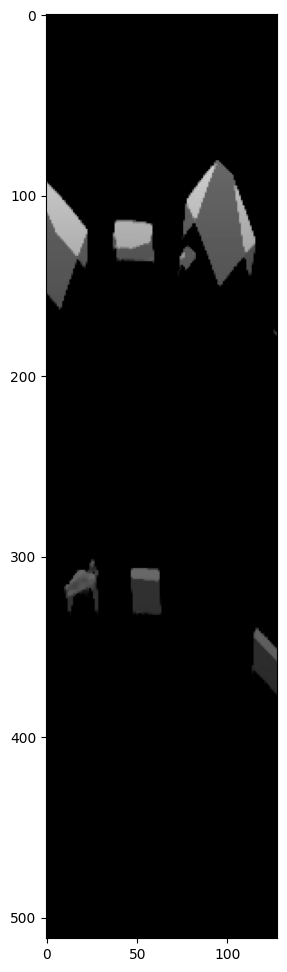

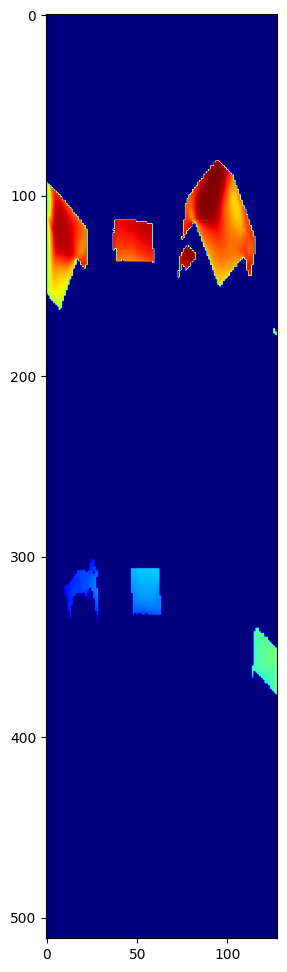

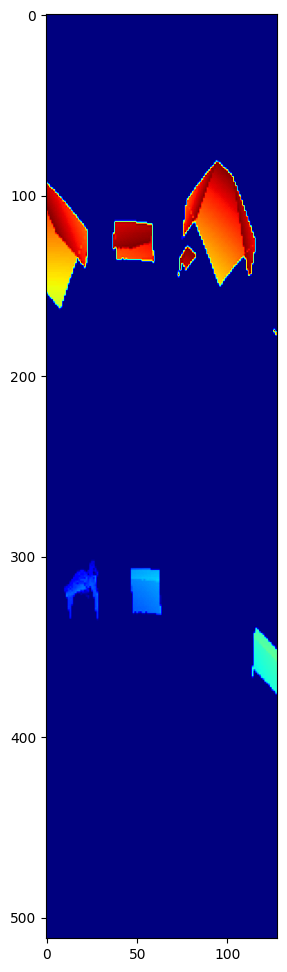

In [29]:
model_path = './sim_ele_data/checkpoints/sim_2023_11_14//19.pth'
model.load_state_dict(torch.load(model_path))

for i, data in enumerate(all_dl):
        
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
    if i>8:
        break
#model_path = 'E:/real-data/checkpoint_ddv/2.pth'    
#model.load_state_dict(torch.load(model_path))       
#model.eval()
ac = ac*mask
ele = model(ac)

ele = ele*mask

warp_mask1,valid_mask1 = inverse_warp(mask_next,ele_gt,mask,motion2) #pose111
warp_mask2,valid_mask2 = inverse_warp(mask_previous,ele_gt,mask,motion1)
    
ele = ele#*warp_mask1*warp_mask2
ele_gt = ele_gt#*warp_mask1*warp_mask2


plt.figure(figsize=(12,12))
acc = ac.to('cpu').detach().numpy().copy()
acc = acc[0]
plt.imshow(acc.squeeze(),cmap=plt.cm.gray)
plt.clim(0,1)

plt.figure(figsize=(12,12))
tester = ele.to('cpu').detach().numpy().copy()
testers = tester[0]


plt.imshow(testers.squeeze(),cmap=plt.cm.jet)
plt.clim(0,1)

plt.figure(figsize=(12,12))
gt = ele_gt.to('cpu').detach().numpy().copy()
gt = gt[0]

plt.imshow(gt.squeeze(),cmap=plt.cm.jet)

print(np.mean(np.abs(gt-testers)))

In [30]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    counts=0
    for i,data in enumerate(train_dl):
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
        ac = ac*mask
        ele = model(ac)
        ele = ele*mask
        diff_metric = ele-ele_gt*mask
            
        metric = diff_metric.abs().mean()
        test_loss = test_loss + metric.item()
        counts = counts+1
        #print(metric.item())
    print('Epoch: %d Average Test loss: %.4f' %(epoch + 1,test_loss/counts))

Epoch: 25 Average Test loss: 0.0055


/tmp/ipykernel_6173/3954801758.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,12))


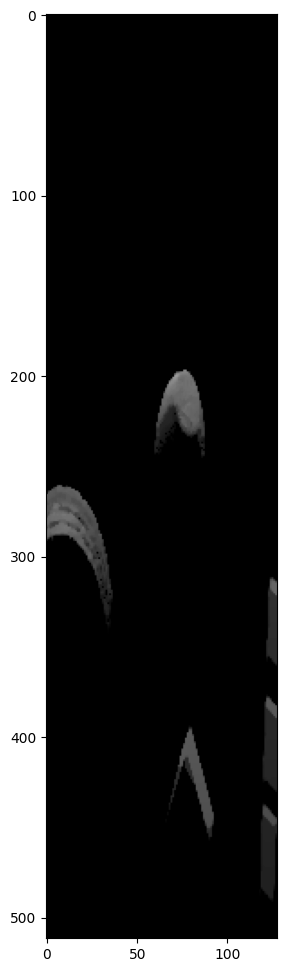

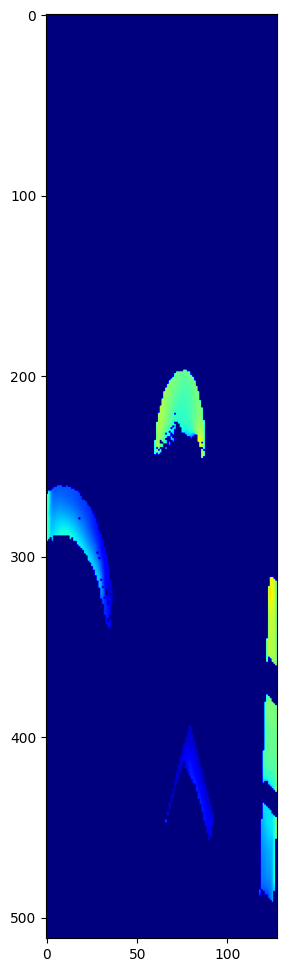

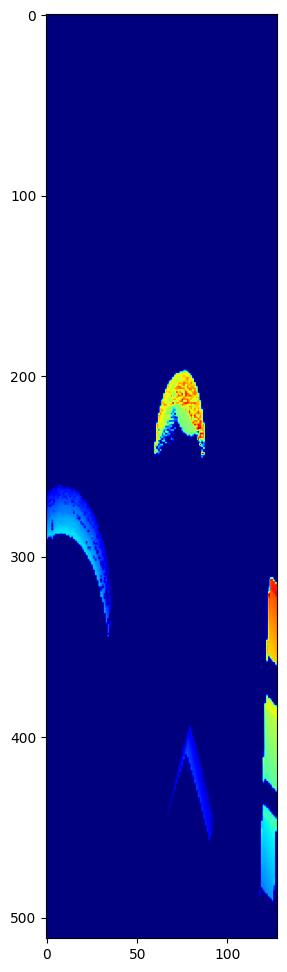

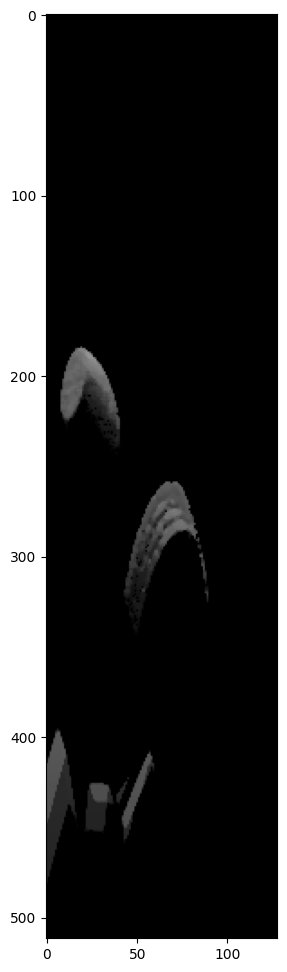

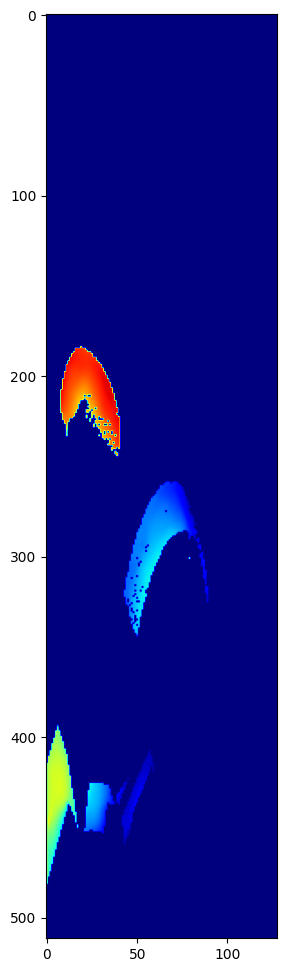

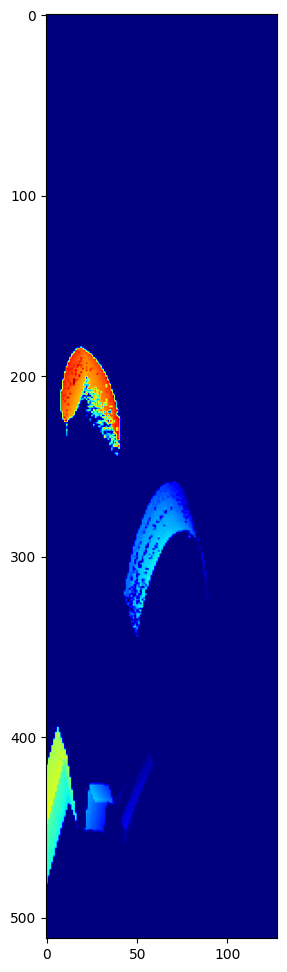

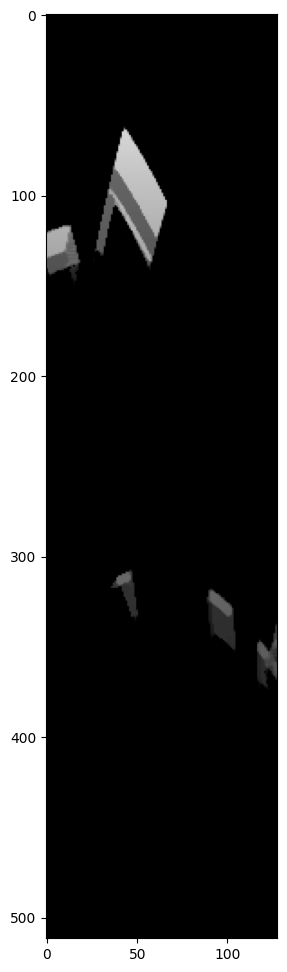

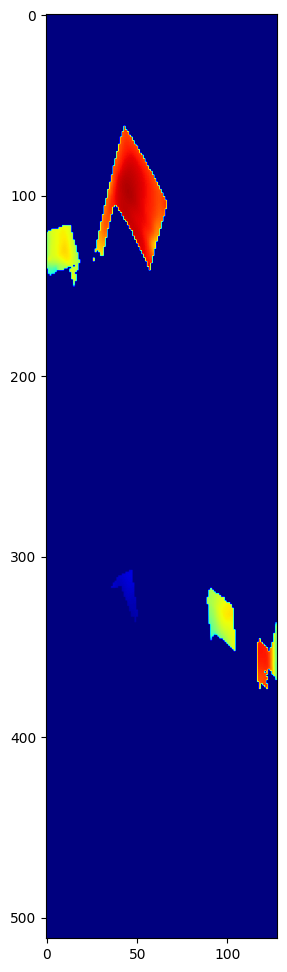

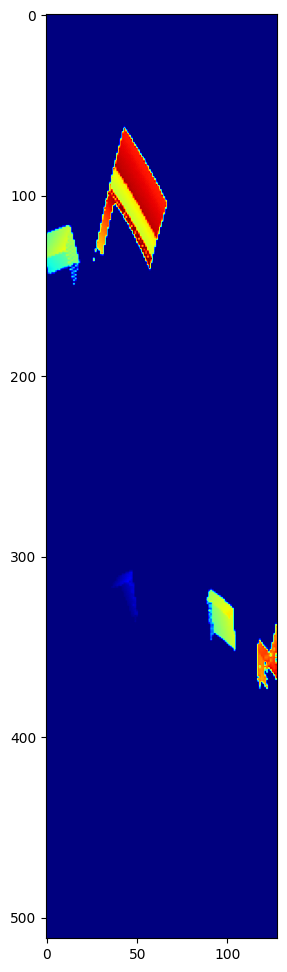

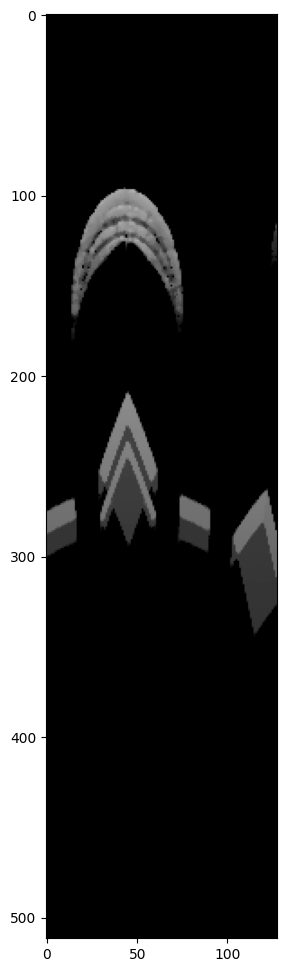

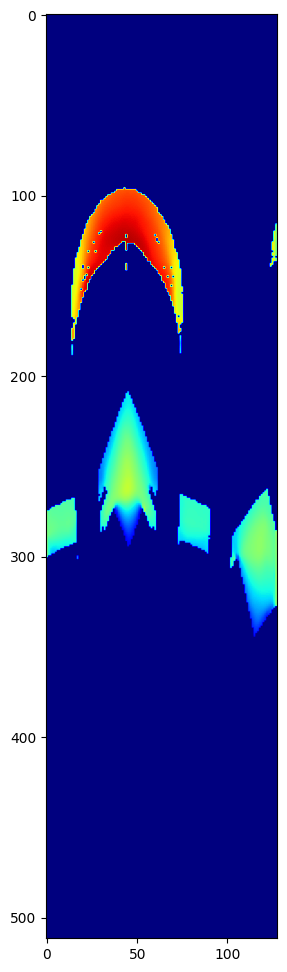

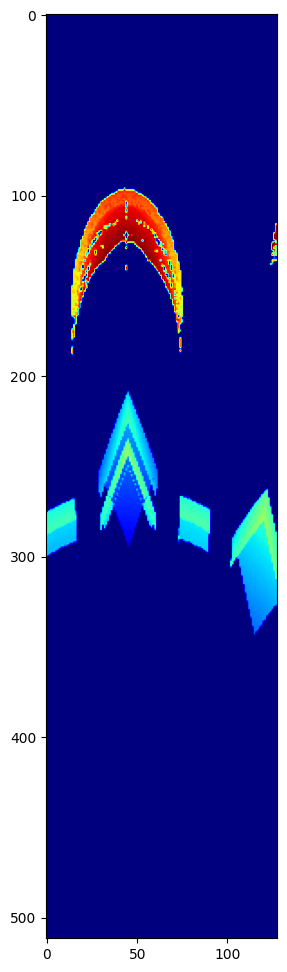

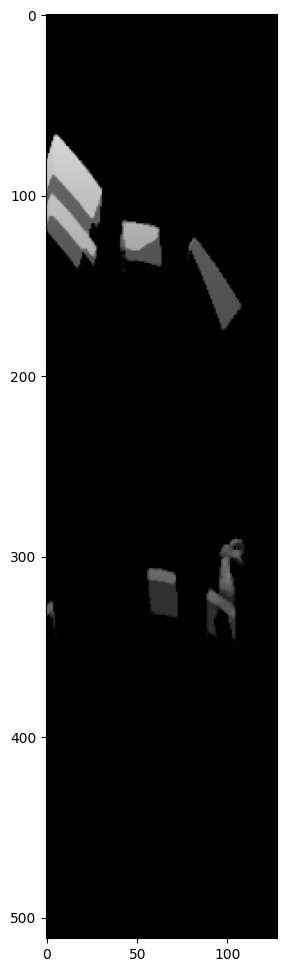

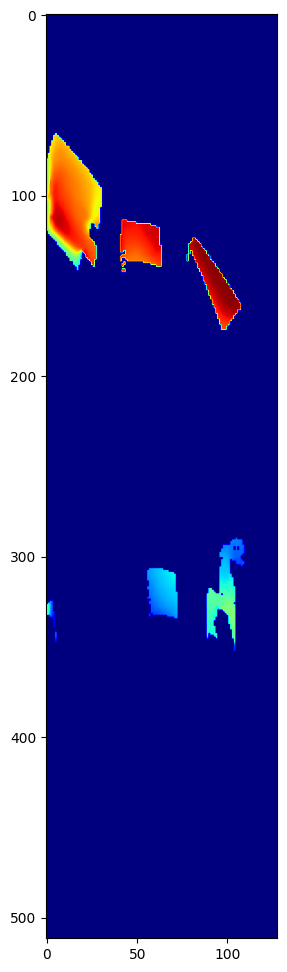

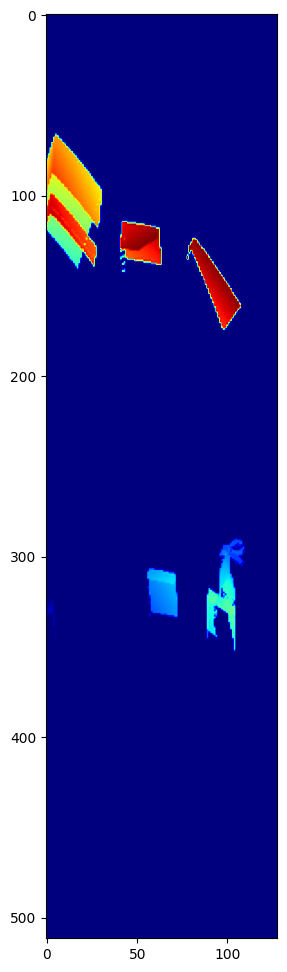

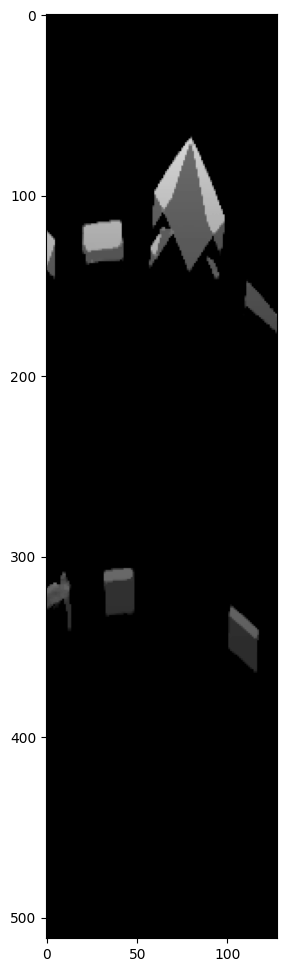

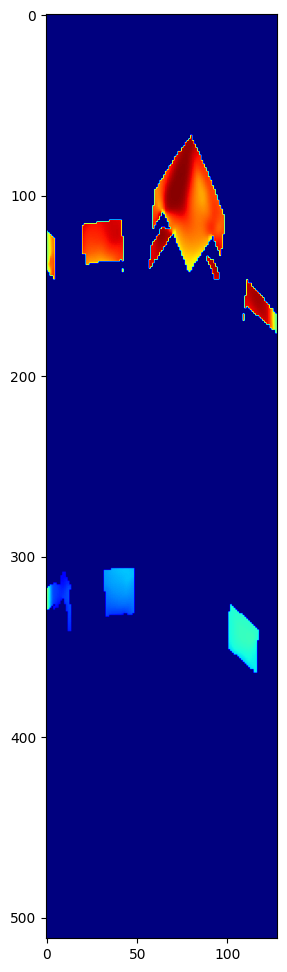

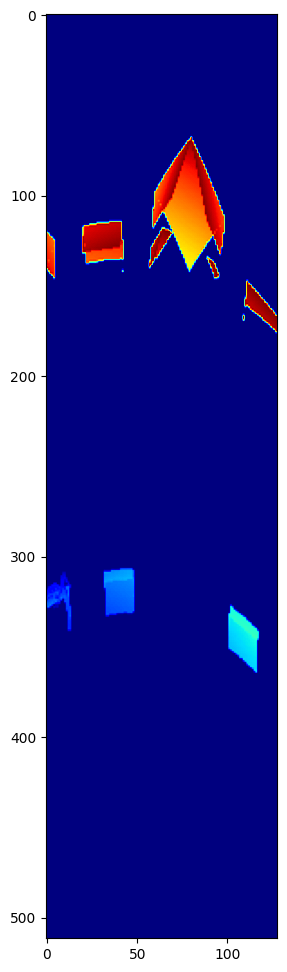

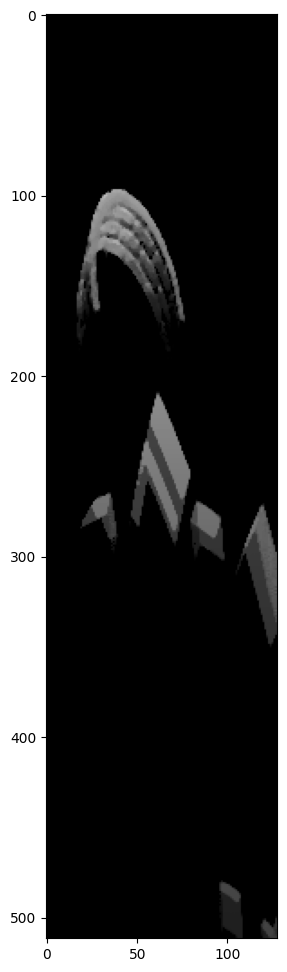

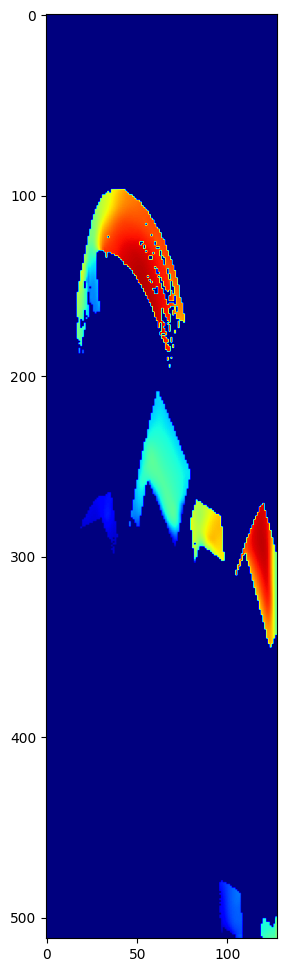

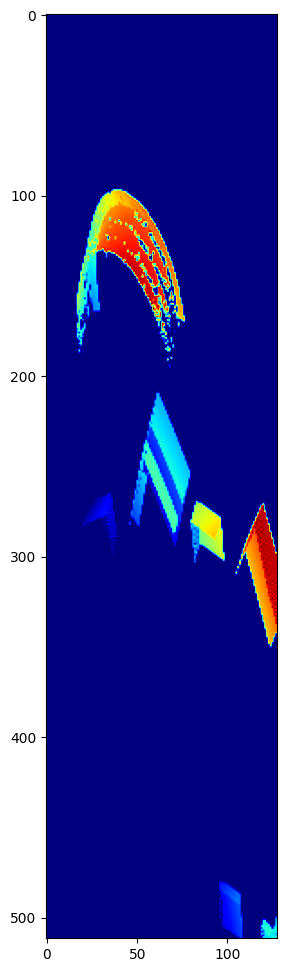

In [31]:
for i, data in enumerate(all_dl):
        
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
    #if i>88:
        #break
    model.eval()
    ac = ac*mask
    ele = model(ac)

    ele = ele*mask


    ele_gt = ele_gt*mask    


    plt.figure(figsize=(12,12))
    acc = ac.to('cpu').detach().numpy().copy()
    acc = acc[0]
    plt.imshow(acc.squeeze(),cmap=plt.cm.gray)
    plt.clim(0,1)

    plt.figure(figsize=(12,12))
    tester = ele.to('cpu').detach().numpy().copy()
    testers = tester[0]


    plt.imshow(testers.squeeze(),cmap=plt.cm.jet)
    plt.clim(0,1)

    plt.figure(figsize=(12,12))
    gt = ele_gt.to('cpu').detach().numpy().copy()
    gt = gt[0]
    plt.imshow(gt.squeeze(),cmap=plt.cm.jet)
    if i>5:
        break
#model_path = 'E:/real-data/checkpoint_ddv/2.pth'    
#model.load_state_dict(torch.load(model_path))       


# Visualize the results and save

In [32]:
import matplotlib.colors
def make_image(data, outputname,min_bar=0.0,max_bar=1.0, size=(1, 4), dpi=100):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('jet')
    norm = matplotlib.colors.Normalize(vmin=min_bar,vmax=max_bar)
    ax.imshow(data, aspect='equal',norm=norm)
    #ax.set_clim(0,512)
    plt.savefig(outputname, dpi=dpi)
    plt.close(fig)
def make_image_gray(data, outputname, min_bar=0.0,max_bar=1.0, size=(1, 4), dpi=100):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('gray')
    norm = matplotlib.colors.Normalize(vmin=min_bar,vmax=max_bar)
    ax.imshow(data, aspect='equal',norm=norm)
    plt.savefig(outputname, dpi=dpi)
    plt.close(fig)

In [33]:
import matplotlib.colors

In [34]:
model.eval()
#model_path = './Checkpoints/UNetCheckpoint_real/best.pth'
#model.load_state_dict(torch.load(model_path))
with torch.no_grad():
    for i,data in enumerate(train_dl): #train_dl
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
        ac = ac*mask
        ele = model(ac)
        ele = ele*mask
        
        # Create directory if not exists
        output_directory = './sim_ele_data/output_sim/roll/'
        os.makedirs(output_directory, exist_ok=True)  # This ensures that the directory exists


        acc = ac.to('cpu').detach().numpy()
        min_bar = 0
        max_bar = 1
        path = './sim_ele_data/output_sim/roll/ac'+str(i)+'.png'
        make_image_gray(acc[0].squeeze(),path)
    
        eg = ele_gt.to('cpu').detach().numpy()
        min_bar = 0
        max_bar = 1
        path = './sim_ele_data/output_sim/roll/ele_gt'+str(i)+'.png'
        make_image(eg[0].squeeze(),path,0,1)
    
        el = ele.to('cpu').detach().numpy()
        min_bar = 0
        max_bar = 1
        path = './sim_ele_data/output_sim/roll/ele'+str(i)+'.png'
        make_image(el[0].squeeze(),path,0,1)
    
    
    
        if i>20:
            break

In [35]:
#model.eval()
#model_path = './Checkpoints/UNetCheckpoint_real/best.pth'
#model.load_state_dict(torch.load(model_path))
with torch.no_grad():
    for i,data in enumerate(test_dl): #test_dl
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
        #ac = ac*mask
        #ele = model(ac)
        #ele = ele*mask

        # Create directory if it doesn't exist
        output_directory = './sim_ele_data/output_sim/raw/'
        os.makedirs(output_directory, exist_ok=True)  # This ensures that the directory exists

        acc = ac.to('cpu').detach().numpy()
        min_bar = 0
        max_bar = 1
        path = './sim_ele_data/output_sim/raw/ac'+str(i)+'.png'
        make_image_gray(acc[0].squeeze(),path)
    

# Elevation map to point cloud

In [36]:
def ele2pc_output(ele,mask): #depth: batch, channel, elevation, azimuth [b,c,e,a]  [1,1,32,128]
    scale=700/512
    angle=18
    
    ele = ele*mask
    ele = ele*angle-angle/2
        
    
    #print(ele.shape)
    aa = (ele<9)
    bb = (ele>-9)
    valid = (aa&bb)
  
    
    ele=ele/180.0*PI
    #global pixel_coords
    b,c,e,a = ele.size()
    valid = valid.reshape(b,-1)
    
    
    i_range = torch.arange(0, e).view(1, e, 1).expand(1,e,a).type_as(ele)*(scale*0.00299)+0.971+400*(0.00299)  # 48.55 optical camera aperture
    i_range = i_range
    j_range = torch.arange(0, a).view(1, 1, a).expand(1,e,a).type_as(ele)/128*(30.0)-(30.0/2)  #-32
    j_range = j_range/180.0*PI
    ones = torch.ones(1,e,a).type_as(ele)
    
    #print(i_range.shape)
    

    
    pixel_coords = torch.stack((j_range, i_range, ones), dim=1)
    
    
    current_pixel_coords = pixel_coords[:,:,:e,:a].expand(b,3,e,a)
    
    ones_exp = torch.ones(b,e,a).type_as(ele)

    ele_exp = torch.stack((ones_exp, ones_exp, ele.squeeze(1)), dim=1)
    
    current_pixel_coords= ele_exp*current_pixel_coords
    
    #print(current_pixel_coords.shape)
   
    #print(current_pixel_coords[:,2,:,:]/PI*180)
    
    x = current_pixel_coords[:,1,:,:]*torch.cos(current_pixel_coords[:,0,:,:])*torch.cos(current_pixel_coords[:,2,:,:])
    y = current_pixel_coords[:,1,:,:]*torch.sin(current_pixel_coords[:,0,:,:])*torch.cos(current_pixel_coords[:,2,:,:])
    z = current_pixel_coords[:,1,:,:]*torch.sin(current_pixel_coords[:,2,:,:])
    
    
    pc = torch.stack((x, y, z), dim=1)
    
    
    
    pc = pc.view(b,3,-1)
    #pc = pc.transpose(1,2)
    pc = pc*valid.unsqueeze(1).float()
    #valid =valid.unsqueeze(2)
    
    #print(pc.shape)
    
    return pc,valid

motion2 shape:  torch.Size([4, 6])
torch.Size([3, 65536])
torch.Size([3, 65536])


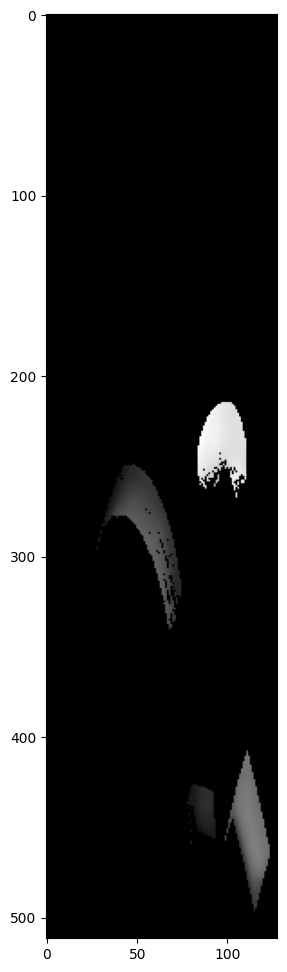

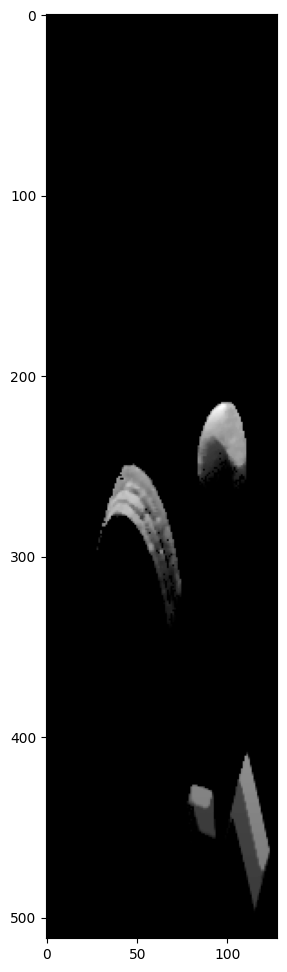

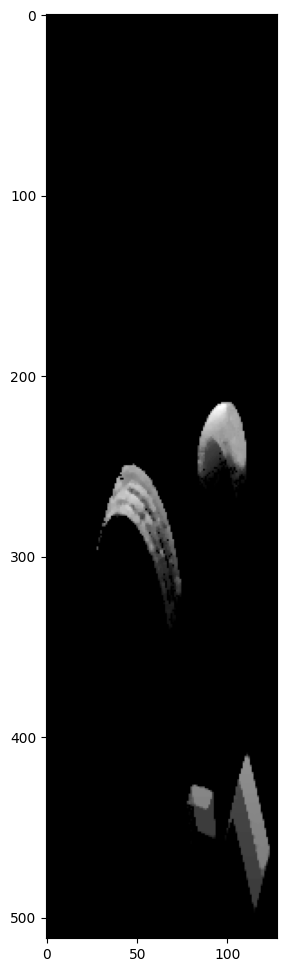

In [37]:
#model_path = './checkpoints/real_20230209/current_sc.pth'
#model.load_state_dict(torch.load(model_path))

for i, data in enumerate(train_dl):
        
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
        #if i>5:
        break
#model_path = 'E:/real-data/checkpoint_ddv/2.pth'    
#model.load_state_dict(torch.load(model_path))       
model.eval()
ac = ac*mask
ele = model(ac)

acx=ac
print('motion2 shape: ', motion2.shape)
warp1,valid1 = inverse_warp(ac_next,ele,mask,motion2)

ele = ele*mask
pc,valid = ele2pc_output(ele,mask)



pc = pc[0]
print(pc.shape)
pc=pc.transpose(0,1)
pc =pc.to('cpu').detach().numpy().copy()
np.savetxt('./sim_ele_data/sampleR.txt',pc)

pc,valid = ele2pc_output(ele_gt,mask)

pc = pc[0]
print(pc.shape)
pc=pc.transpose(0,1)
pc =pc.to('cpu').detach().numpy().copy()
np.savetxt('./sim_ele_data/gtR.txt',pc)



#np.savetxt('gtA.txt',pc_gt)


warp1 = warp1*mask



plt.figure(figsize=(12,12))
tester = ele.to('cpu').detach().numpy().copy()
testers = tester[0]

plt.imshow(testers.squeeze())

plt.figure(figsize=(12,12))
wp = warp1.to('cpu').detach().numpy().copy()
wps = wp[0]

plt.imshow(wps.squeeze())

ac=ac*mask
plt.figure(figsize=(12,12))
acc = ac.to('cpu').detach().numpy().copy()
acs = acc[0]

plt.imshow(acs.squeeze())

#vis_pr=torch.max(pr,dim=1,keepdim=True)
    #max_pr = torch.max(pr,dim=1)
    #print(max_pr[1])
    #print(pr[:,max_pr[1],:,:])
    #print(vis_pr[0].shape)



In [38]:
model.eval()

for i,data in enumerate(all_dl): #test_dl
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
    ac = ac*mask
    ele = model(ac)
    ele = ele*mask
    
    pc,valid = ele2pc_output(ele,mask)


    pc = pc[0]
    print(pc.shape)
    pc=pc.transpose(0,1)
    pc =pc.to('cpu').detach().numpy().copy()
    np.savetxt('./sim_ele_data/sampleR.txt',pc)
    
    pc,valid = ele2pc_output(ele_gt,mask)

    pc = pc[0]
    print(pc.shape)
    pc=pc.transpose(0,1)
    pc =pc.to('cpu').detach().numpy().copy()
    np.savetxt('./sim_ele_data/gtR.txt',pc)
    
    break

torch.Size([3, 65536])
torch.Size([3, 65536])


In [39]:
model.eval()

for i, data in enumerate(all_dl):
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda(), front.cuda()
    ac = ac*mask
    ele = model(ac)
    ele = ele*mask
    ele_gt = ele_gt*mask
    
    ele = ele[0].squeeze().to('cpu').detach().numpy()

    pc1 = torch.zeros([512, 64, 128], dtype=torch.float32)
    sfront = torch.zeros([64, 128], dtype=torch.float32)
    
    ele = np.clip(ele,0,0.99)
    ele = ele*64
    ele = ele.astype(dtype = np.int64)
    
    mask = mask.squeeze()



    for m in range(512):
        for j in range(128):
             if mask[m, j].item() > 0:
                k = ele[m][j]
                #print(k)
                pc1[m][k][j] = 1
                sfront[k][j] = m
    
    pcr = torch.zeros([512, 64, 128], dtype=torch.float32)
    
    sfront = torch.tensor(sfront,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    #sfront = F.interpolate(sfront,(32,64), mode='bicubic')
    sfront = sfront.squeeze()
    #sfront[sfront<1]=511
    #sfront[sfront>512]=511
    
    for m in range(64):
        for j in range(128):
            if sfront[m][j]>5 and sfront[m][j]<512:
                k = int(sfront[m][j])
                #jd = int(j/2)
                pcr[k][m][j] = 1
    
    data = torch.nonzero(pcr).numpy().astype(dtype = np.int64)
    #path = '/data/share/wang/maskgt'+str(i)+'.txt'
    #np.savetxt(path,data)
    
    
    r1=0.971+0.00299*400+data[:,0]*(0.00299*(700/512))
    phi=np.deg2rad(-9+data[:,1]/64*18)
    theta=np.deg2rad(-15+data[:,2]/128*30)
    
    length = len(data[:,0])
    
    test_pc1 = np.zeros([length,3], dtype=np.float32)
    
    test_pc1[:,0]=r1*np.sin(theta)*np.cos(phi)
    test_pc1[:,1]=-r1*np.sin(phi)
    test_pc1[:,2]=-r1*np.cos(theta)*np.cos(phi)

    # Create directory if it doesn't exist
    output_directory = './sim_ele_data/result_sim/roll_blender/'
    os.makedirs(output_directory, exist_ok=True)  # This ensures that the directory exists
    
    
    path = './sim_ele_data/result_sim/roll_blender/test'+str(i)+'.txt'
    np.savetxt(path,test_pc1)

    # not complete gt point cloud
    ele_gt = ele_gt[0].squeeze().to('cpu').detach().numpy()

    pc2 = torch.zeros([512, 64, 128], dtype=torch.float32)
    sfront2 = torch.zeros([64, 128], dtype=torch.float32)
    
    ele_gt = np.clip(ele_gt,0,0.99)
    ele_gt = ele_gt*64
    ele_gt = ele_gt.astype(dtype = np.int64)
    
    mask = mask.squeeze()



    for m in range(512):
        for j in range(128):
             if mask[m, j].item() > 0:
                k2 = ele_gt[m][j]
                pc2[m][k2][j] = 1
                sfront2[k2][j] = m
    
    pcr2 = torch.zeros([512, 64, 128], dtype=torch.float32)
    
    sfront2 = torch.tensor(sfront2,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    sfront2 = sfront2.squeeze()
    
    for m in range(64):
        for j in range(128):
            if sfront2[m][j]>5 and sfront2[m][j]<512:
                k2 = int(sfront2[m][j])
                pcr2[k2][m][j] = 1
    
    data2 = torch.nonzero(pcr2).numpy().astype(dtype = np.int64)
    
    
    r12=0.971+0.00299*400+data2[:,0]*(0.00299*(700/512))
    phi2=np.deg2rad(-9+data2[:,1]/64*18)
    theta2=np.deg2rad(-15+data2[:,2]/128*30)
    
    length2 = len(data2[:,0])
    
    test_pc2 = np.zeros([length2,3], dtype=np.float32)
    
    test_pc2[:,0]=r12*np.sin(theta2)*np.cos(phi2)
    test_pc2[:,1]=-r12*np.sin(phi2)
    test_pc2[:,2]=-r12*np.cos(theta2)*np.cos(phi2)
    
    path = './sim_ele_data/result_sim/roll_blender/nComp'+str(i)+'.txt'
    np.savetxt(path,test_pc2)
    
    
    # gt point cloud
    y = front.to('cpu').detach().numpy().copy()
    
    gt= y[0]
    
    pc1 = torch.zeros([512, 64, 128], dtype=torch.float32)
    
    r1 = (gt-0.971-0.00299*400)/(0.00299*(700/512))
    r1 = r1.astype(dtype = np.int64)
    r1[r1<0]=0
    r1[r1>511]=0
    
    r1 = r1.astype(dtype = np.int64)
    #print(r)
    
    
    for m in range(64):
        for j in range(128):
            if r1[m][j]>0:
                k = r1[m][j]
                pc1[k][m][j] = 1
    data = torch.nonzero(pc1).numpy()
    #path = '/data/share/wang/maskgt'+str(i)+'.txt'
    #np.savetxt(path,data)
    
    
    r1=0.971+0.00299*400+data[:,0]*(0.00299*(700/512))
    
    phi=np.deg2rad(-9+data[:,1]/64*18)
    theta=np.deg2rad(-15+data[:,2]/128*30)
    
    length = len(data[:,0])
    
    euc_pc1 = np.zeros([length,3], dtype=np.float32)
    
    euc_pc1[:,0]=r1*np.sin(theta)*np.cos(phi)
    euc_pc1[:,1]=-r1*np.sin(phi)
    euc_pc1[:,2]=-r1*np.cos(theta)*np.cos(phi)
    
    path = './sim_ele_data/result_sim/roll_blender/gt'+str(i)+'.txt'
    np.savetxt(path,euc_pc1)
    
    
    
        #resize
    #break    
    #==================================================

/tmp/ipykernel_6173/2518158257.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sfront = torch.tensor(sfront,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
/tmp/ipykernel_6173/2518158257.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sfront2 = torch.tensor(sfront2,dtype=torch.float32).unsqueeze(0).unsqueeze(0)


# Quantitative evaluation

In [40]:
!git clone https://github.com/ThibaultGROUEIX/ChamferDistancePytorch

fatal: destination path 'ChamferDistancePytorch' already exists and is not an empty directory.


In [41]:
import torch, time
import ChamferDistancePytorch.chamfer_python
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import ChamferDistancePytorch.fscore as fscore
import scipy.spatial.distance

In [42]:
list = []
for i in range(1):
    P = np.loadtxt("./sim_ele_data/result_sim/roll_blender/gt"+str(i)+".txt")
    Q = np.loadtxt("./sim_ele_data/result_sim/roll_blender/test"+str(i)+".txt")
    
    P = torch.tensor(P)
    Q = torch.tensor(Q)
    
    mydist1, mydist2, myidx1, myidx2 = ChamferDistancePytorch.chamfer_python.distChamfer(P.unsqueeze(0), Q.unsqueeze(0))
    
    dist = mydist1.mean()*500+mydist2.mean()*500
    list.append(dist)

In [43]:
print(np.mean(list))

1.6428434


In [1]:
list = []
acc = []
com = []
list_fscore1 = []
list_fscore2 = []
hausdorff_list = []
for i in range(30):
    P = np.loadtxt("./sim_ele_data/result_sim/roll_blender/gt"+str(i)+".txt")
    Q = np.loadtxt("./sim_ele_data/result_sim/roll_blender/test"+str(i)+".txt")
    
    P = torch.tensor(P)
    Q = torch.tensor(Q)
    
    mydist1, mydist2, myidx1, myidx2 = ChamferDistancePytorch.chamfer_python.distChamfer(P.unsqueeze(0), Q.unsqueeze(0))
    com.append(mydist1.mean()*500)
    acc.append(mydist2.mean()*500)
    
    dist = mydist1.mean()*500+mydist2.mean()*500
    list.append(dist)
    
    f_score, precision, recall = fscore.fscore(mydist1, mydist2,0.001)
    list_fscore1.append(f_score)
    
    f_score, precision, recall = fscore.fscore(mydist1, mydist2,0.003)
    list_fscore2.append(f_score)

    dist = scipy.spatial.distance.directed_hausdorff(P, Q)[0]  # Only take the distance value, not the indices
    hausdorff_list.append(dist)


NameError: name 'np' is not defined

In [45]:
print(np.mean(list))

3.3265193


In [46]:
print(np.mean(hausdorff_list))

0.6795403818687048


In [47]:
print(np.mean(list_fscore1))

0.5428237


In [48]:
print(np.mean(list_fscore2))

0.78615576


In [49]:
#1.2250342 2.7297041 1.7363062

In [50]:
print(np.mean(com))

2.1707227


In [51]:
print(np.mean(acc))

1.1557962


In [52]:
import numpy as np
import pandas as pd
import torch
import scipy.spatial
import ChamferDistancePytorch
import ChamferDistancePytorch.fscore as fscore

def process_image(image_index):
    # Load your data
    P = np.loadtxt(f"./sim_ele_data/result_sim/roll_blender/gt{image_index}.txt")
    Q = np.loadtxt(f"./sim_ele_data/result_sim/roll_blender/test{image_index}.txt")
    
    P_tensor = torch.tensor(P)
    Q_tensor = torch.tensor(Q)
    
    mydist1, mydist2, _, _ = ChamferDistancePytorch.chamfer_python.distChamfer(P_tensor.unsqueeze(0), Q_tensor.unsqueeze(0))
    
    # Calculate metrics and convert tensor to float
    com = mydist1.mean().item() * 500
    acc = mydist2.mean().item() * 500
    dist = com + acc
    
    f_score1, _, _ = fscore.fscore(mydist1, mydist2, 0.001)
    f_score1 = f_score1.item()

    f_score2, _, _ = fscore.fscore(mydist1, mydist2, 0.003)
    f_score2 = f_score2.item()

    hausdorff_dist = scipy.spatial.distance.directed_hausdorff(P, Q)[0]

    # Return data as a dictionary with a unique image name
    return {
        'image_name': f'test_{image_index + 1}',  # Unique identifier for each image
        'index': image_index,
        'comb_dist': dist,
        'com': com,
        'acc': acc,
        'f_score_1': f_score1,
        'f_score_2': f_score2,
        'haus_dist': hausdorff_dist
    }

# Process images and create DataFrame
data = [process_image(i) for i in range(30)]
df = pd.DataFrame(data)

# Set the image name as the index of the DataFrame
df.set_index('image_name', inplace=True)

# Save to CSV
df.to_csv('image_metrics.csv')

# Display the DataFrame
print(df.head())  # Display first few rows for verification


            index  comb_dist       com       acc  f_score_1  f_score_2  \
image_name                                                               
test_1          0   1.642843  1.236628  0.406215   0.747352   0.932783   
test_2          1   2.845893  1.598518  1.247376   0.623337   0.854112   
test_3          2   4.048512  2.841143  1.207369   0.467957   0.723485   
test_4          3   2.121412  1.382166  0.739246   0.569404   0.885843   
test_5          4   6.803641  6.091970  0.711671   0.528902   0.756692   

            haus_dist  
image_name             
test_1       0.734504  
test_2       0.433369  
test_3       0.779520  
test_4       0.438460  
test_5       1.306524  


In [53]:
import ChamferDistancePytorch.fscore as fscore
import matplotlib.pyplot as plt

f_score, precision, recall = fscore.fscore(mydist1, mydist2,0.002)
print(f_score)

tensor([0.5726])


TypeError: Invalid shape (128,) for image data

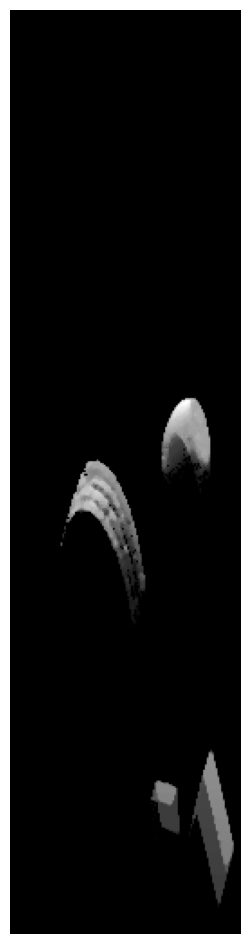

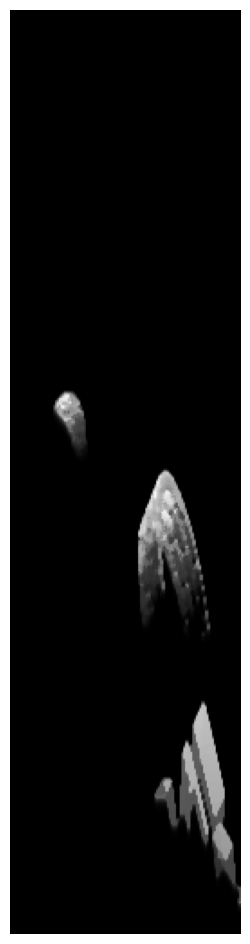

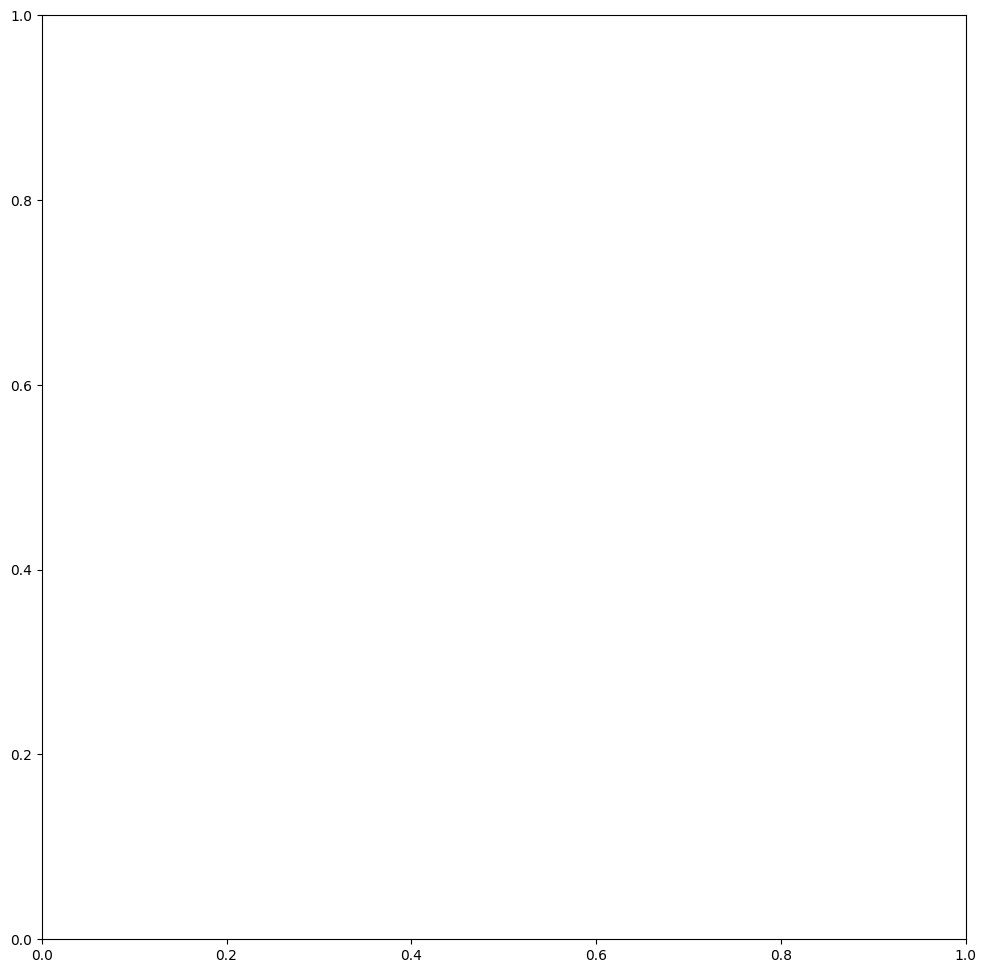

In [54]:

# For acx
plt.figure(figsize=(12,12))
img = acx[0].to('cpu').detach().numpy().squeeze()  # Select the first image and squeeze
plt.imshow(img, cmap='gray')
plt.axis('off')

# For ac_next
plt.figure(figsize=(12,12))
img = ac_next[0].to('cpu').detach().numpy().squeeze()  # Select the first image and squeeze
plt.imshow(img, cmap='gray')
plt.axis('off')

# Reshape the image to 2D if necessary
if mask.ndim == 1:
    side_length = int(np.sqrt(mask.size(0)))
    mask = mask.reshape(side_length, side_length)

# Now you can safely squeeze since mask is at least 2D
img = mask[0].to('cpu').detach().numpy().squeeze()

# Visualize the image
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='viridis')
plt.axis('off')

# For mask_next
plt.figure(figsize=(12,12))
print("Shape of img:", img.shape)

img = mask_next[0].to('cpu').detach().numpy().squeeze()  # Select the first image and squeeze
plt.imshow(img, cmap='viridis')
plt.axis('off')

# Compute pc and valid
print("Shape of ele before compute_3dpts_batch:", ele.shape)
print("Shape of mask before compute_3dpts_batch:", mask.shape)
ele_tensor = torch.tensor(ele).cuda()
pc, valid = compute_3dpts_batch(ele_tensor, mask)
print("Shape of pc:", pc.shape)
print("Shape of valid:", valid.shape)

'''
# Compute norm
print("Shape of ele before depth2normal_layer_batch:", ele.shape)
print("Shape of mask before depth2normal_layer_batch:", mask.shape)
norm = depth2normal_layer_batch(ele, mask)
print("Shape of norm:", norm.shape)

# For norm
plt.figure(figsize=(12,12))
img = norm[0].to('cpu').detach().numpy().squeeze()  # Select the first image and squeeze
plt.imshow(img, cmap='viridis')
plt.axis('off')
'''

torch.Size([3, 65536])


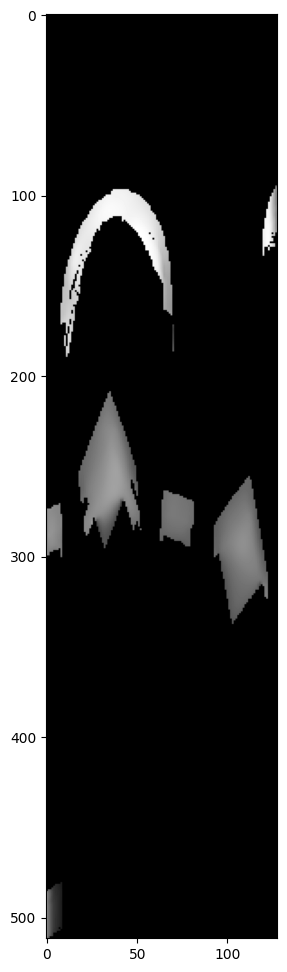

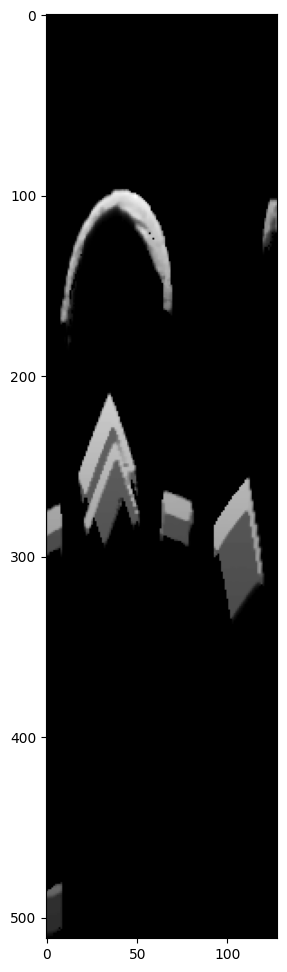

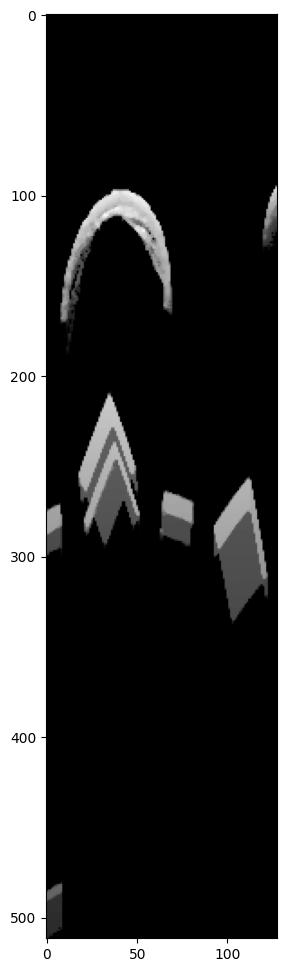

In [ ]:
#print("Length of data:", len(data))

for i, data in enumerate(train_dl):
        
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
        
    break
        
model.eval()

ele = model(ac)

warp1,valid1 = inverse_warp(ac_next,ele,mask,motion2)

ele = ele*mask
pc,valid = ele2pc_output(ele,mask)



pc = pc[0]
print(pc.shape)
pc=pc.transpose(0,1)
pc =pc.to('cpu').detach().numpy().copy()
np.savetxt('./sim_ele_data/sampleB.txt',pc)



#np.savetxt('gtA.txt',pc_gt)


warp1 = warp1*mask



plt.figure(figsize=(12,12))
tester = ele.to('cpu').detach().numpy().copy()
testers = tester[0]

plt.imshow(testers.squeeze())

plt.figure(figsize=(12,12))
wp = warp1.to('cpu').detach().numpy().copy()
wps = wp[0]

plt.imshow(wps.squeeze())

ac=ac*mask
plt.figure(figsize=(12,12))
acc = ac.to('cpu').detach().numpy().copy()
acs = acc[0]

plt.imshow(acs.squeeze())

In [ ]:
print(2.89/970)

0.0029793814432989693


In [ ]:

model = UNet()
model = model.cuda()

In [ ]:
scale=624/256

model.eval()
model_path = '.sim_ele_data/checkpoints/sim_2023_11_14//19.pth'
model.load_state_dict(torch.load(model_path))

for i, data in enumerate(test_dl): #test_dl
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, *_ = data
    ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
    output = model(ac)
    output = output*mask
    
    ele = output[0].squeeze().to('cpu').detach().numpy()

    pc1 = torch.zeros([256, 32, 128], dtype=torch.float32)
    sfront = torch.zeros([32, 128], dtype=torch.float32)
    
    #print(ele.min())
    #print(ele.max())
    ele = np.clip(ele,0,1)
    ele = ele*31
    ele = ele.astype(dtype = np.int64)
    
    
    
    for m in range(256):
        for j in range(128):
            if ele[m][j]>0:
                k = ele[m][j]
                #print(k)
                pc1[m][k][j] = 1
                sfront[k][j] = m
    
    
    #pc1 = F.interpolate(pc1.unsqueeze(0),(32,64), mode='bicubic')
    #pc1 = pc1.squeeze()
    #print(pc1.shape)
    
    pcr = torch.zeros([256, 32, 64], dtype=torch.float32)
    
    sfront = torch.tensor(sfront,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    #sfront = F.interpolate(sfront,(32,64), mode='bicubic')
    sfront = sfront.squeeze()
    #sfront[sfront<1]=511
    #sfront[sfront>512]=511
    
    for m in range(32):
        for j in range(128):
            if sfront[m][j]>5 and sfront[m][j]<256:
                k = int(sfront[m][j])
                jd = int(j/2)
                pcr[k][m][jd] = 1
    
    data = torch.nonzero(pcr).numpy().astype(dtype = np.int64)
    #path = '/data/share/wang/maskgt'+str(i)+'.txt'
    #np.savetxt(path,data)
    
    
    r1=0.971+400*(0.00299)+data[:,0]*(scale*0.00299)
    phi=np.deg2rad(-9+data[:,1]/32*18)
    theta=np.deg2rad(-15+data[:,2]/64*30)
    
    length = len(data[:,0])
    
    test_pc1 = np.zeros([length,3], dtype=np.float32)
    
    test_pc1[:,0]=r1*np.cos(theta)*np.cos(phi)
    test_pc1[:,1]=r1*np.sin(theta)*np.cos(phi)
    test_pc1[:,2]=r1*np.sin(phi)
    
    # Before saving the file, check if the directory exists and create it if necessary
    output_directory = './sim_ele_data/pc/unet_sim/'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    path = './sim_ele_data/pc/unet_sim/all_dl'+str(i)+'.txt'
    np.savetxt(path,test_pc1)
        #resize
    if i>5:
        break    
    #==================================================
    '''
    ele = ele_gt[0].squeeze().to('cpu').detach().numpy()

    pc1 = torch.zeros([512, 32, 128], dtype=torch.float32)
    sfront = torch.zeros([32, 128], dtype=torch.float32)
    
    #print(ele.min())
    #print(ele.max())
    ele = np.clip(ele,0,1)
    ele = ele*31
    ele = ele.astype(dtype = np.int64)
    
    
    
    for m in range(512):
        for j in range(128):
            if ele[m][j]>0:
                k = ele[m][j]
                #print(k)
                pc1[m][k][j] = 1
                sfront[k][j] = m
    
    
    #pc1 = F.interpolate(pc1.unsqueeze(0),(32,64), mode='bicubic')
    #pc1 = pc1.squeeze()
    #print(pc1.shape)
    
    pcr = torch.zeros([512, 32, 64], dtype=torch.float32)
    
    sfront = torch.tensor(sfront,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    #sfront = F.interpolate(sfront,(32,64), mode='bicubic')
    sfront = sfront.squeeze()
    #sfront[sfront<1]=511
    #sfront[sfront>512]=511
    
    for m in range(32):
        for j in range(128):
            if sfront[m][j]>5 and sfront[m][j]<512:
                k = int(sfront[m][j])
                jd = int(j/2)
                pcr[k][m][jd] = 1
    
    data = torch.nonzero(pcr).numpy().astype(dtype = np.int64)
    #path = '/data/share/wang/maskgt'+str(i)+'.txt'
    #np.savetxt(path,data)
    
    
    r1=2.2+data[:,0]*0.003
    phi=np.deg2rad(-7+data[:,1]/32*14)
    theta=np.deg2rad(-15+data[:,2]/64*30)
    
    length = len(data[:,0])
    
    test_pc1 = np.zeros([length,3], dtype=np.float32)
    
    test_pc1[:,0]=r1*np.cos(theta)*np.cos(phi)
    test_pc1[:,1]=r1*np.sin(theta)*np.cos(phi)
    test_pc1[:,2]=r1*np.sin(phi)
    
    path = './results/unet_arti/gt'+str(i)+'.txt'
    np.savetxt(path,test_pc1)
    '''

FileNotFoundError: [Errno 2] No such file or directory: '.sim_ele_data/checkpoints/sim_2023_11_14//19.pth'

In [ ]:
import json
import pickle
from PIL import Image
import numpy as np

json_path = './transforms.json' 
with open(json_path) as f:
    di = json.load(f)

#train_dl = DataLoader(acoustic_dataset,batch_size=1,shuffle=False)

#model.eval()
#model_path = './Checkpoints/UNetCheckpoint_real/best.pth'
#model.load_state_dict(torch.load(model_path))
with torch.no_grad():
    for i,data in enumerate(test_dl):
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2, front = data
        ac, ele_gt, mask, ac_previous, ele_previous_gt, mask_previous, ac_next, ele_next_gt, mask_next, motion1, motion2 = ac.cuda(), ele_gt.cuda(), mask.cuda(), ac_previous.cuda(), ele_previous_gt.cuda(), mask_previous.cuda(), ac_next.cuda(), ele_next_gt.cuda(), mask_next.cuda(), motion1.cuda(), motion2.cuda()
        ac = ac*mask
        #ele = model(ac)
        #ele = ele*mask

        np_image = ac.to('cpu').detach().numpy()
        #np_ele = ele.to('cpu').detach().numpy()
        np_ele_gt = ele_gt.to('cpu').detach().numpy()
        pose  = np.array(di['frames'][i]['transform_matrix'])

        data = {
            'ImagingSonar': np_image.squeeze(),
            'PoseSensor': pose,
            #'elemap': np_ele.squeeze(),
            'elemap_gt': np_ele_gt.squeeze()
        }

        save_path = '../neusis/data/nerf-ground-real-mask/Data/'+str(i)+'.pkl'
        with open(save_path, 'wb') as f:
            pickle.dump(data, f)

        #print(np_ele.max())

        #break


        

FileNotFoundError: [Errno 2] No such file or directory: './transforms.json'

In [ ]:
minimum_depth = 0.971+0.00299*400
maximum_depth = 0.971+0.00299*1100

print(minimum_depth)
print(maximum_depth)

2.167
4.26
